In [1]:
import pandas as pd

# Loading dataset
ind_df = pd.read_csv('../data/indigenous_collection_processed.csv', index_col='id')
print(f'Dataframe columns: \n{ind_df.columns}')

Dataframe columns: 
Index(['url', 'thumbnail', 'creation_date', 'modification_date',
       'numero_do_item', 'tripticos', 'categoria', 'nome_do_item',
       'nome_do_item_dic', 'colecao', 'coletor', 'doador', 'modo_de_aquisicao',
       'data_de_aquisicao', 'ano_de_aquisicao', 'data_de_confeccao', 'autoria',
       'nome_etnico', 'descricao', 'dimensoes', 'funcao', 'materia_prima',
       'tecnica_confeccao', 'descritor_tematico', 'descritor_comum',
       'numero_de_pecas', 'itens_relacionados', 'responsavel_guarda',
       'inst_detentora', 'povo', 'autoidentificacao', 'lingua',
       'estado_de_origem', 'geolocalizacao', 'pais_de_origem', 'exposicao',
       'referencias', 'disponibilidade', 'qualificacao', 'historia_adm',
       'notas_gerais', 'observacao', 'conservacao', 'image_path'],
      dtype='object')


In [2]:
import importlib
from IPython.core.magic import register_cell_magic

# Creating skip cell command
@register_cell_magic
def skip(line, cell):
    return

In [3]:
# Centralizing main imports so we can run the models separately
import random
from tqdm.notebook import tqdm
from PIL import Image

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms

import matplotlib.pyplot as plt

from image_training_utils import *

# import image_training_utils
# importlib.reload(image_training_utils)
# from image_training_utils import *

# Image Clustering

Clustering experiments with image feature extractors. The idea is to fine-tune some pre-trained transformer models on our dataset and then remove the last layer of the model to cluster on the embedding space projections.

## Dataset Preparation

For fine-tuning the model on our dataset, we are going to try a couple different labels (*povo* and *categoria*) and study how they affect the generated emebdding space.

In [4]:
# Filtering out corrupted images
corrupted_images = []
for index, row in ind_df.loc[ind_df['image_path'].notna()].iterrows():
    try:
        Image.open('../'+row['image_path'])
    except Exception as e:
        corrupted_images.append(row['image_path'])
        ind_df.loc[index, 'image_path'] = pd.NA
print(f'{len(corrupted_images)} corrupted images')

# Creating 'image_path_br' column
ind_df['image_path_br'] = ind_df['image_path'].values
ind_df.loc[ind_df['image_path_br'].notna(), 'image_path_br'] = \
    ind_df.loc[ind_df['image_path_br'].notna(), \
               'image_path'].apply(lambda path: \
                                   f"data/br_images/{path.split('/')[-1].split('.')[0]}.png")

1 corrupted images


## ViT Base Patch-16

### Pre-trained Embedding Space

In [5]:
# Getting the proper device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Building dataset for column 'povo' (though no specific column is used on off-the-shelf model)
vit_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
povo_labels, povo_name_to_num, povo_num_to_name = preparing_image_labels(ind_df, 'povo')
povo_dataset = ImageDataset(povo_labels, transform=vit_transform, augment=False)

In [6]:
# Projecting data onto the off-the-shelf pre-trained embedding space from ViT
from transformers import ViTModel

# Loading model
model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
model.to(device)

# Getting data
povo_dataloader = DataLoader(povo_dataset, batch_size=512, shuffle=True, \
                             num_workers=0, pin_memory=True)

# Computing image embeddings
image_embeddings, vanilla_image_indices = get_embeddings(model, povo_dataloader, device)
image_embeddings = np.concatenate(image_embeddings, axis=0)
vanilla_image_indices = np.concatenate(vanilla_image_indices, axis=0)

# Computing data projection
vanilla_vit_trimap, vanilla_vit_tsne, vanilla_vit_umap = data_projections(image_embeddings)

# Cleaning up memory
clean_mem([model, image_embeddings])

Computing embeddings: 100%|█████████████████████████████████████████| 23/23 [03:01<00:00,  7.89s/it]
/home/lui/anaconda3/envs/ind_thesis/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


### Fine-Tuning Embedding Space

In [7]:
# Creating our own ViT classifier (multi-)head for fine-tuning
class ViTClassifier(nn.Module):
    def __init__(self, num_classes1, num_classes2=0, freeze=0):
        super(ViTClassifier, self).__init__()
        self.vit = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
        self.classifier1 = nn.Linear(self.vit.config.hidden_size, num_classes1)
        self.multi_head = False
        
        # Multi-head architecture
        if num_classes2 > 0:
            self.classifier2 = nn.Linear(self.vit.config.hidden_size, num_classes2)
            self.multi_head = True
        
        self.freeze_layers(freeze)

    def forward(self, x):
        outputs = self.vit(x)
        
        # Getting embeddings from last_hidden_state of CLS token (maybe pooler_output?)
        embeddings = outputs['last_hidden_state'][:, 0, :]
        # embeddings = outputs['pooler_output']

        logits1 = self.classifier1(embeddings)
        if self.multi_head:
            logits2 = self.classifier2(embeddings)
            return logits1, logits2
        return logits1

    # Freezing early layers so we don't lose generalization and speed up training
    def freeze_layers(self, freeze):
        if freeze <= 0:
            return

        # Accounting for the embedding freeze
        freeze -= 1
        
        for name, param in self.vit.named_parameters():
            if "embeddings" in name:
                param.requires_grad = False
            elif int(name.split('.')[2]) < freeze:
                param.requires_grad = False
            else:
                break

#### *povo* Column

In [8]:
# Studying data distribution to filter out rare classes
povo_categories, categories_keys, categories_freq, \
qs, masks = study_class_distribution(povo_labels)

# Filtering classes so that we retain around 85% of data
povo_filtered_categories = {}
povo_filtered_categories_names = {}
for c in masks[3][0]:
    povo_filtered_categories[categories_keys[c]] = povo_categories[categories_keys[c]]
    
    povo_filtered_categories_names[povo_num_to_name[categories_keys[c]]] = \
    povo_categories[categories_keys[c]]

Quantile X Data Percentage:
Q-10: 1.00, 99.84% of data
Q-25: 4.00, 99.18% of data
Q-50: 19.00, 95.96% of data
Q-75: 65.75, 83.18% of data
Q-90: 158.20, 63.25% of data



In [9]:
# Filtering dataframe for selected categories
threshold_multiplier = 2
minority_classes, majority_classes, labels_minority, labels_majority, \
val_labels, test_labels, povo_augmented_dataset, povo_balanced_val_dataset, \
povo_balanced_test_dataset = filter_image_data_distribution(ind_df, \
                                                            povo_filtered_categories_names, \
                                                            vit_transform, \
                                                            threshold_multiplier, \
                                                            'povo')

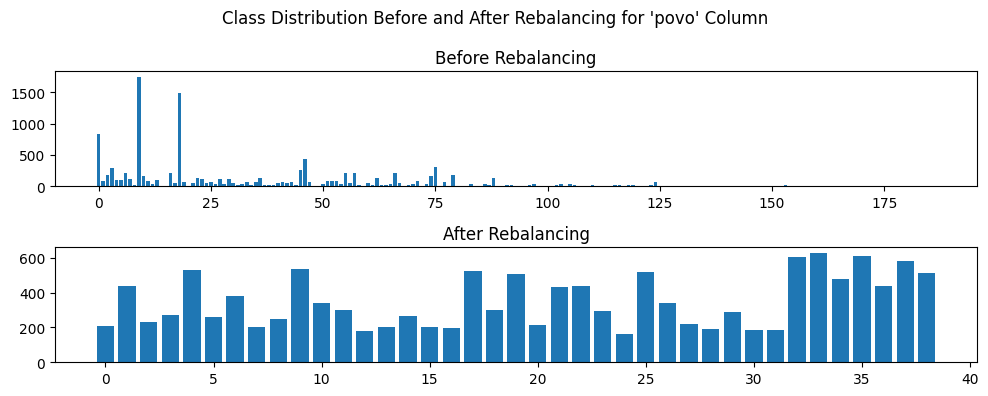

In [10]:
# Plotting old and new class distributions
plot_class_distributions(povo_categories, povo_filtered_categories, labels_minority, \
                         labels_majority, threshold_multiplier, 'povo')

In [11]:
# Because the dataset is still unbalanced, we also create class weights for the loss function
povo_class_weights = compute_class_weights(povo_filtered_categories, labels_minority, \
                                           labels_majority, device, threshold_multiplier)

Training model:   5%|██▎                                          | 1/20 [04:06<1:18:10, 246.86s/it]

Best model saved at epoch 1
Epoch 1, Loss: 1099.7066, Validation Accuracy: 0.3310


Training model:  10%|████▌                                        | 2/20 [08:15<1:14:22, 247.90s/it]

Best model saved at epoch 2
Epoch 2, Loss: 808.8097, Validation Accuracy: 0.4335


Training model:  15%|██████▊                                      | 3/20 [12:23<1:10:12, 247.78s/it]

Best model saved at epoch 3
Epoch 3, Loss: 624.5989, Validation Accuracy: 0.5054


Training model:  20%|█████████                                    | 4/20 [16:28<1:05:48, 246.80s/it]

Best model saved at epoch 4
Epoch 4, Loss: 464.4089, Validation Accuracy: 0.5429


Training model:  25%|███████████▎                                 | 5/20 [20:34<1:01:35, 246.39s/it]

Best model saved at epoch 5
Epoch 5, Loss: 330.3684, Validation Accuracy: 0.5695


Training model:  30%|██████████████                                 | 6/20 [24:39<57:25, 246.09s/it]

Best model saved at epoch 6
Epoch 6, Loss: 226.8950, Validation Accuracy: 0.6020


Training model:  35%|████████████████▍                              | 7/20 [28:42<53:07, 245.17s/it]

Best model saved at epoch 7
Epoch 7, Loss: 148.9825, Validation Accuracy: 0.6276


Training model:  40%|██████████████████▊                            | 8/20 [32:46<48:55, 244.63s/it]

Best model saved at epoch 8
Epoch 8, Loss: 93.6995, Validation Accuracy: 0.6512


Training model:  45%|█████████████████████▏                         | 9/20 [36:48<44:41, 243.81s/it]

Epoch 9, Loss: 60.5626, Validation Accuracy: 0.6463


Training model:  50%|███████████████████████                       | 10/20 [40:47<40:24, 242.42s/it]

Best model saved at epoch 10
Epoch 10, Loss: 41.3589, Validation Accuracy: 0.6522


Training model:  55%|█████████████████████████▎                    | 11/20 [44:44<36:06, 240.78s/it]

Epoch 11, Loss: 29.6813, Validation Accuracy: 0.6384


Training model:  60%|███████████████████████████▌                  | 12/20 [48:42<31:58, 239.79s/it]

Epoch 12, Loss: 21.7878, Validation Accuracy: 0.6493


Training model:  65%|█████████████████████████████▉                | 13/20 [52:40<27:54, 239.24s/it]

Epoch 13, Loss: 16.0394, Validation Accuracy: 0.6463


Training model:  70%|████████████████████████████████▏             | 14/20 [56:37<23:52, 238.80s/it]

Epoch 14, Loss: 36.9648, Validation Accuracy: 0.5951


Training model:  70%|██████████████████████████████▊             | 14/20 [1:00:35<25:57, 259.66s/it]

Early-stopping training!


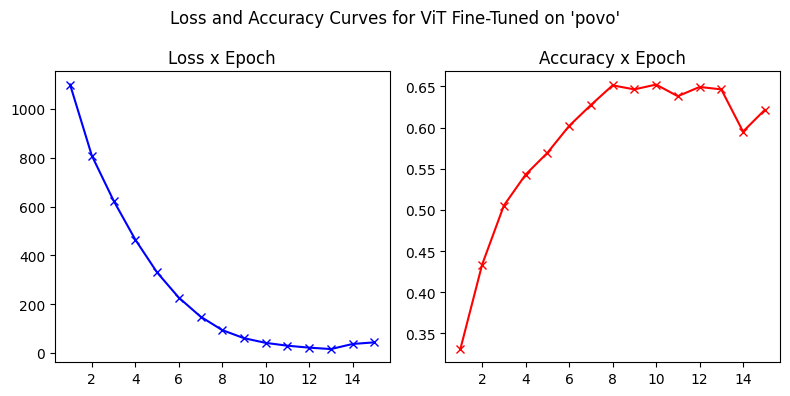

/home/lui/Documents/uva/thesis/tainacan_collection/image_based/image_training_utils.py:687: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('../data/mo

Validation accuracy: 0.65234375
Validation average per class precision: 0.2866
Validation average per class recall: 0.2550

Test accuracy: 0.6894409656524658
Test average per class precision: 0.2648
Test average per class recall: 0.2520

Test average precision on filtered classes: 0.6070692313787265
Test average recall on filtered classes: 0.6229626945196054


In [12]:
# Recreating datasets for proper training and testing
povo_train_val_labels = povo_labels.copy()
povo_test_labels_aux = random.sample(list(povo_train_val_labels), \
                                     int(0.1*len(povo_train_val_labels)))
povo_test_labels = {}
for key in povo_test_labels_aux:
    povo_test_labels[key] = povo_train_val_labels[key]
    del povo_train_val_labels[key]
    
povo_train_val_dataset = ImageDataset(povo_train_val_labels, transform=vit_transform, \
                                      augment=False)
povo_test_dataset = ImageDataset(povo_test_labels, transform=vit_transform, augment=False)

# Setting-up training, executing training and then running tests
batch_size = 32
epochs = 20
num_classes = ind_df['povo'].dropna().nunique()
model = ViTClassifier(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters(), lr=5e-5, weight_decay=2e-6)
model_name = 'vit_povo'
column_name = 'povo'

test_prec, test_rec = execute_train_test(povo_train_val_dataset, povo_test_dataset, device, \
                                         batch_size, epochs, num_classes, model, criterion, \
                                         opt, model_name, column_name)
prec_rec_on_selected_classes(povo_categories, povo_filtered_categories, test_prec, test_rec)

# Cleaning up memory
clean_mem([model])

Training model:   5%|██▎                                          | 1/20 [06:56<2:12:01, 416.91s/it]

Best model saved at epoch 1
Epoch 1, Loss: 1395.1673, Validation Accuracy: 0.4069


Training model:  10%|████▌                                        | 2/20 [13:49<2:04:15, 414.19s/it]

Best model saved at epoch 2
Epoch 2, Loss: 1069.8516, Validation Accuracy: 0.5227


Training model:  15%|██████▊                                      | 3/20 [20:39<1:56:47, 412.22s/it]

Best model saved at epoch 3
Epoch 3, Loss: 756.1585, Validation Accuracy: 0.6103


Training model:  20%|█████████                                    | 4/20 [27:36<1:50:26, 414.15s/it]

Best model saved at epoch 4
Epoch 4, Loss: 452.3683, Validation Accuracy: 0.6557


Training model:  25%|███████████▎                                 | 5/20 [34:25<1:43:07, 412.48s/it]

Best model saved at epoch 5
Epoch 5, Loss: 224.4182, Validation Accuracy: 0.6792


Training model:  30%|█████████████▌                               | 6/20 [41:17<1:36:12, 412.35s/it]

Best model saved at epoch 6
Epoch 6, Loss: 106.5183, Validation Accuracy: 0.6948


Training model:  35%|███████████████▋                             | 7/20 [48:08<1:29:13, 411.80s/it]

Best model saved at epoch 7
Epoch 7, Loss: 57.1251, Validation Accuracy: 0.7089


Training model:  40%|██████████████████                           | 8/20 [54:59<1:22:18, 411.56s/it]

Epoch 8, Loss: 36.2600, Validation Accuracy: 0.6995


Training model:  45%|███████████████████▎                       | 9/20 [1:01:46<1:15:11, 410.16s/it]

Epoch 9, Loss: 24.1471, Validation Accuracy: 0.6933


Training model:  50%|█████████████████████                     | 10/20 [1:08:34<1:08:13, 409.39s/it]

Epoch 10, Loss: 24.4102, Validation Accuracy: 0.6854


Training model:  50%|█████████████████████                     | 10/20 [1:15:24<1:15:24, 452.40s/it]

Early-stopping training!


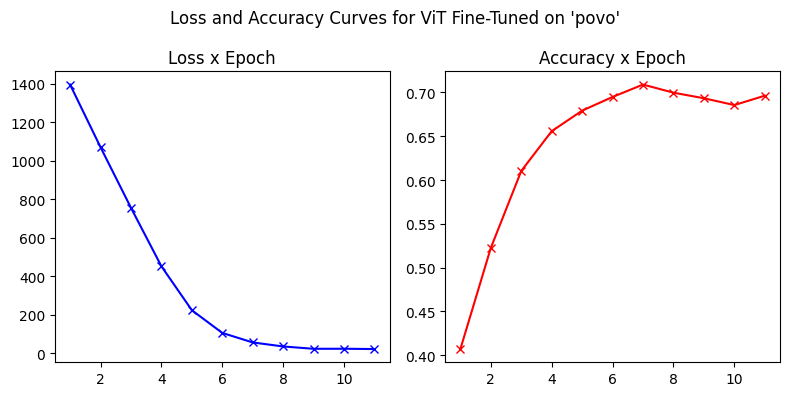

Validation accuracy: 0.708984375
Validation average per class precision: 0.7060
Validation average per class recall: 0.6856

Test accuracy: 0.7212543487548828
Test average per class precision: 0.7173
Test average per class recall: 0.6873



Computing embeddings: 100%|█████████████████████████████████████████| 23/23 [02:43<00:00,  7.13s/it]
/home/lui/anaconda3/envs/ind_thesis/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [13]:
# Retraining model with augmented dataset to see the difference in the results
batch_size = 32
epochs = 20
num_classes = len(povo_filtered_categories)
model = ViTClassifier(num_classes).to(device)
criterion = nn.CrossEntropyLoss(weight=povo_class_weights)
opt = optim.Adam(model.parameters(), lr=2e-5, weight_decay=2e-6)
model_name = 'balanced_vit_povo'
column_name = 'povo'

execute_train_test(povo_augmented_dataset, povo_balanced_test_dataset, device, batch_size, \
                   epochs, num_classes, model, criterion, opt, model_name, column_name, \
                   povo_balanced_val_dataset)

povo_vit_trimap, povo_vit_tsne, \
povo_vit_umap, povo_image_indices = compute_classifier_embeddings(povo_dataloader, model, \
                                                                  device)

# Cleaning up memory
clean_mem([model])

Training model:   5%|██▎                                          | 1/20 [05:29<1:44:12, 329.06s/it]

Best model saved at epoch 1
Epoch 1, Loss: 1439.8840, Validation Accuracy: 0.3850


Training model:  10%|████▌                                        | 2/20 [10:54<1:38:00, 326.72s/it]

Best model saved at epoch 2
Epoch 2, Loss: 1165.8617, Validation Accuracy: 0.4789


Training model:  15%|██████▊                                      | 3/20 [16:11<1:31:24, 322.61s/it]

Best model saved at epoch 3
Epoch 3, Loss: 906.5282, Validation Accuracy: 0.5618


Training model:  20%|█████████                                    | 4/20 [21:29<1:25:28, 320.55s/it]

Best model saved at epoch 4
Epoch 4, Loss: 641.7303, Validation Accuracy: 0.6416


Training model:  25%|███████████▎                                 | 5/20 [26:46<1:19:51, 319.45s/it]

Best model saved at epoch 5
Epoch 5, Loss: 394.3511, Validation Accuracy: 0.6776


Training model:  30%|█████████████▌                               | 6/20 [32:07<1:14:38, 319.91s/it]

Best model saved at epoch 6
Epoch 6, Loss: 210.1658, Validation Accuracy: 0.7089


Training model:  35%|███████████████▋                             | 7/20 [37:25<1:09:11, 319.36s/it]

Best model saved at epoch 7
Epoch 7, Loss: 107.1939, Validation Accuracy: 0.7230


Training model:  40%|██████████████████                           | 8/20 [42:44<1:03:48, 319.00s/it]

Best model saved at epoch 8
Epoch 8, Loss: 58.4765, Validation Accuracy: 0.7261


Training model:  45%|█████████████████████▏                         | 9/20 [48:02<58:26, 318.81s/it]

Epoch 9, Loss: 34.7302, Validation Accuracy: 0.7261


Training model:  50%|███████████████████████                       | 10/20 [53:21<53:08, 318.83s/it]

Epoch 10, Loss: 23.1463, Validation Accuracy: 0.7214


Training model:  55%|█████████████████████████▎                    | 11/20 [58:40<47:51, 319.04s/it]

Epoch 11, Loss: 16.2980, Validation Accuracy: 0.7199


Training model:  60%|██████████████████████████▍                 | 12/20 [1:04:00<42:34, 319.31s/it]

Epoch 12, Loss: 13.3901, Validation Accuracy: 0.7199


Training model:  65%|████████████████████████████▌               | 13/20 [1:09:20<37:15, 319.42s/it]

Epoch 13, Loss: 9.4711, Validation Accuracy: 0.7230


Training model:  70%|██████████████████████████████▊             | 14/20 [1:14:38<31:53, 318.91s/it]

Epoch 14, Loss: 7.1158, Validation Accuracy: 0.7136


Training model:  75%|█████████████████████████████████           | 15/20 [1:19:59<26:38, 319.74s/it]

Epoch 15, Loss: 5.0799, Validation Accuracy: 0.7167


Training model:  80%|███████████████████████████████████▏        | 16/20 [1:25:20<21:20, 320.17s/it]

Epoch 16, Loss: 3.9654, Validation Accuracy: 0.7230


Training model:  85%|█████████████████████████████████████▍      | 17/20 [1:30:39<15:58, 319.59s/it]

Epoch 17, Loss: 3.5122, Validation Accuracy: 0.7136


Training model:  85%|█████████████████████████████████████▍      | 17/20 [1:35:55<16:55, 338.57s/it]

Early-stopping training!


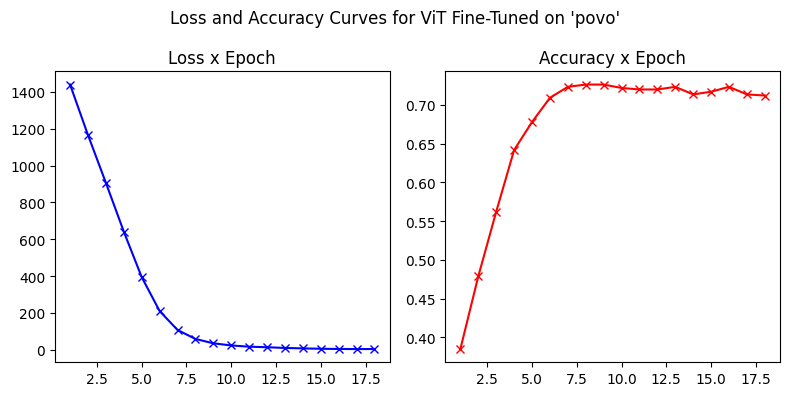

/home/lui/Documents/uva/thesis/tainacan_collection/image_based/image_training_utils.py:687: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('../data/mo

Validation accuracy: 0.72607421875
Validation average per class precision: 0.6990
Validation average per class recall: 0.6991

Test accuracy: 0.7177700400352478
Test average per class precision: 0.6993
Test average per class recall: 0.6977



In [14]:
# Training partially frozen model on balanced dataset to see the difference in results
batch_size = 32
epochs = 20
num_classes = len(povo_filtered_categories)
freeze = 7
model = ViTClassifier(num_classes, freeze=freeze).to(device)
criterion = nn.CrossEntropyLoss(weight=povo_class_weights)
opt = optim.Adam(model.parameters(), lr=2e-5, weight_decay=2e-6)
model_name = 'frozen_vit_povo'
column_name = 'povo'

execute_train_test(povo_augmented_dataset, povo_balanced_test_dataset, device, batch_size, \
                   epochs, num_classes, model, criterion, opt, model_name, column_name, \
                   povo_balanced_val_dataset)

# Cleaning up memory
clean_mem([model])

#### *categoria* Column

In [15]:
# Now rebalancing the 'categoria' column
categoria_labels, categoria_name_to_num, categoria_num_to_name = \
preparing_image_labels(ind_df, 'categoria')
categoria_dataset = ImageDataset(categoria_labels, transform=vit_transform)
categoria_dataloader = DataLoader(categoria_dataset, batch_size=512, shuffle=True, \
                                  num_workers=0, pin_memory=True)

categoria_categories, categories_keys, categories_freq, qs, \
masks = study_class_distribution(categoria_labels)

# Filtering out 'etnobotânica' (and 'armas')
filter_out = [categoria_name_to_num['etnobotânica']]
categoria_filtered_categories = {}
categoria_filtered_categories_names = {}
for c in set(categoria_name_to_num.values()) - set(filter_out):
    categoria_filtered_categories[categories_keys[c]] = \
    categoria_categories[categories_keys[c]]
    
    categoria_filtered_categories_names[categoria_num_to_name[categories_keys[c]]] = \
    categoria_categories[categories_keys[c]]

Quantile X Data Percentage:
Q-10: 216.60, 99.71% of data
Q-25: 507.50, 93.33% of data
Q-50: 1060.50, 79.68% of data
Q-75: 1344.50, 58.09% of data
Q-90: 2270.70, 26.50% of data



In [16]:
# Filtering dataframe for selected categories
threshold_multiplier = 1.5
minority_classes, majority_classes, labels_minority, labels_majority, val_labels, \
test_labels, categoria_augmented_dataset, categoria_balanced_val_dataset, \
categoria_balanced_test_dataset = \
filter_image_data_distribution(ind_df, categoria_filtered_categories_names, vit_transform, \
                               threshold_multiplier, 'categoria')

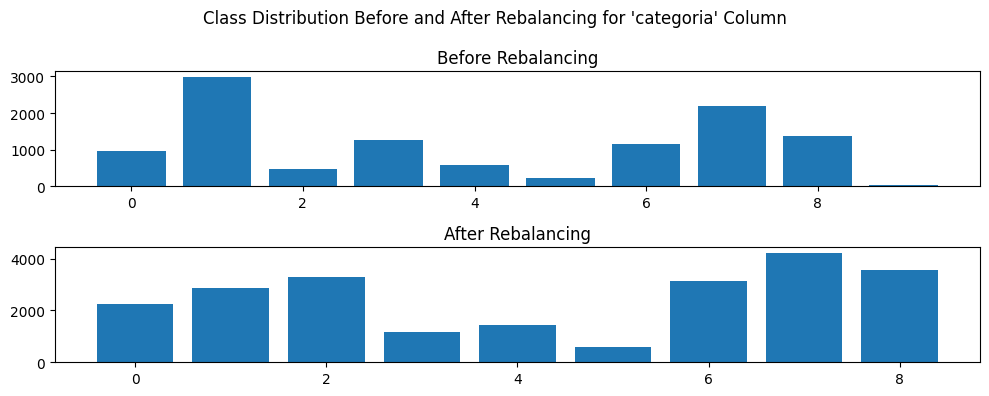

In [17]:
# Plotting old and new class distributions
plot_class_distributions(categoria_categories, categoria_filtered_categories, \
                         labels_minority, labels_majority, threshold_multiplier, 'categoria')

In [18]:
# Because the dataset is still unbalanced, we also create class weights for the loss function
categoria_class_weights = compute_class_weights(categoria_filtered_categories, \
                                                labels_minority, labels_majority, device, \
                                                threshold_multiplier)

Training model:   5%|██▎                                          | 1/20 [04:03<1:17:12, 243.80s/it]

Best model saved at epoch 1
Epoch 1, Loss: 481.7884, Validation Accuracy: 0.6217


Training model:  10%|████▌                                        | 2/20 [08:06<1:12:55, 243.07s/it]

Best model saved at epoch 2
Epoch 2, Loss: 298.4834, Validation Accuracy: 0.7882


Training model:  15%|██████▊                                      | 3/20 [12:04<1:08:12, 240.75s/it]

Best model saved at epoch 3
Epoch 3, Loss: 209.6266, Validation Accuracy: 0.8374


Training model:  20%|█████████                                    | 4/20 [16:02<1:03:55, 239.71s/it]

Best model saved at epoch 4
Epoch 4, Loss: 150.7445, Validation Accuracy: 0.8522


Training model:  25%|███████████▊                                   | 5/20 [20:00<59:45, 239.05s/it]

Best model saved at epoch 5
Epoch 5, Loss: 106.4125, Validation Accuracy: 0.8562


Training model:  30%|██████████████                                 | 6/20 [23:58<55:40, 238.63s/it]

Best model saved at epoch 6
Epoch 6, Loss: 78.4040, Validation Accuracy: 0.8581


Training model:  35%|████████████████▍                              | 7/20 [27:56<51:39, 238.44s/it]

Best model saved at epoch 7
Epoch 7, Loss: 57.5479, Validation Accuracy: 0.8700


Training model:  40%|██████████████████▊                            | 8/20 [31:52<47:32, 237.72s/it]

Epoch 8, Loss: 42.1688, Validation Accuracy: 0.8690


Training model:  45%|█████████████████████▏                         | 9/20 [35:48<43:31, 237.37s/it]

Epoch 9, Loss: 32.9417, Validation Accuracy: 0.8680


Training model:  50%|███████████████████████                       | 10/20 [39:45<39:32, 237.22s/it]

Epoch 10, Loss: 26.1601, Validation Accuracy: 0.8700


Training model:  55%|█████████████████████████▎                    | 11/20 [43:43<35:34, 237.21s/it]

Best model saved at epoch 11
Epoch 11, Loss: 21.8469, Validation Accuracy: 0.8808


Training model:  60%|███████████████████████████▌                  | 12/20 [47:39<31:36, 237.10s/it]

Epoch 12, Loss: 19.2470, Validation Accuracy: 0.8778


Training model:  65%|█████████████████████████████▉                | 13/20 [51:36<27:39, 237.10s/it]

Epoch 13, Loss: 17.1515, Validation Accuracy: 0.8759


Training model:  70%|████████████████████████████████▏             | 14/20 [55:34<23:42, 237.11s/it]

Epoch 14, Loss: 15.9210, Validation Accuracy: 0.8749


Training model:  75%|██████████████████████████████████▌           | 15/20 [59:31<19:45, 237.06s/it]

Epoch 15, Loss: 15.7379, Validation Accuracy: 0.8562


Training model:  80%|███████████████████████████████████▏        | 16/20 [1:03:28<15:48, 237.06s/it]

Epoch 16, Loss: 11.7274, Validation Accuracy: 0.8778


Training model:  85%|█████████████████████████████████████▍      | 17/20 [1:07:25<11:51, 237.18s/it]

Epoch 17, Loss: 8.1919, Validation Accuracy: 0.8788


Training model:  90%|███████████████████████████████████████▌    | 18/20 [1:11:22<07:53, 236.99s/it]

Epoch 18, Loss: 9.9554, Validation Accuracy: 0.8571


Training model:  90%|███████████████████████████████████████▌    | 18/20 [1:15:19<08:22, 251.10s/it]

Early-stopping training!


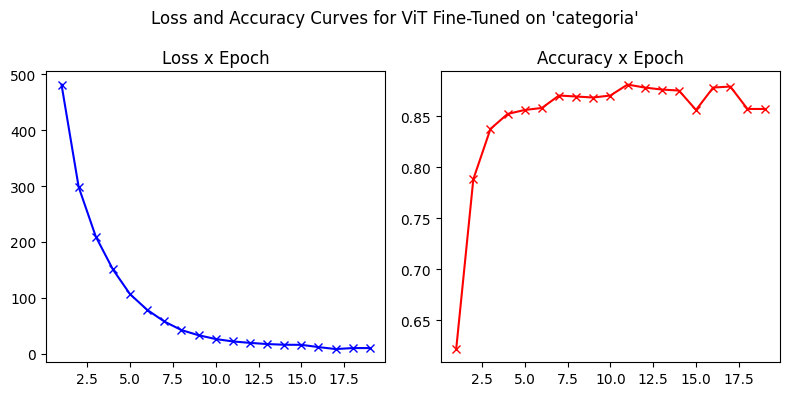

/home/lui/Documents/uva/thesis/tainacan_collection/image_based/image_training_utils.py:687: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('../data/mo

Validation accuracy: 0.880859375
Validation average per class precision: 0.7737
Validation average per class recall: 0.7715

Test accuracy: 0.8669033050537109
Test average per class precision: 0.7530
Test average per class recall: 0.7676

Test average precision on filtered classes: 0.8366950551668803
Test average recall on filtered classes: 0.85284423828125


In [19]:
# Recreating datasets for proper training and testing
categoria_train_val_labels = categoria_labels.copy()
categoria_test_labels_aux = random.sample(list(categoria_train_val_labels), \
                                          int(0.1*len(categoria_train_val_labels)))
categoria_test_labels = {}
for key in categoria_test_labels_aux:
    categoria_test_labels[key] = categoria_train_val_labels[key]
    del categoria_train_val_labels[key]
    
categoria_train_val_dataset = ImageDataset(categoria_train_val_labels, \
                                           transform=vit_transform, augment=False)
categoria_test_dataset = ImageDataset(categoria_test_labels, \
                                      transform=vit_transform, augment=False)

# Setting-up training, executing training and then running tests
batch_size = 32
epochs = 20
num_classes = ind_df['categoria'].dropna().nunique()
model = ViTClassifier(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters(), lr=1e-5, weight_decay=2e-6)
model_name = 'vit_categoria'
column_name = 'categoria'

test_prec, test_rec = execute_train_test(categoria_train_val_dataset, categoria_test_dataset, \
                                         device, batch_size, epochs, num_classes, model, \
                                         criterion, opt, model_name, column_name)
prec_rec_on_selected_classes(categoria_categories, categoria_filtered_categories, test_prec, \
                             test_rec)

# Cleaning up memory
clean_mem([model])

Training model:   5%|██▎                                          | 1/20 [11:28<3:37:52, 688.03s/it]

Best model saved at epoch 1
Epoch 1, Loss: 2455.9443, Validation Accuracy: 0.7121


Training model:  10%|████▌                                        | 2/20 [22:55<3:26:17, 687.63s/it]

Best model saved at epoch 2
Epoch 2, Loss: 1465.3568, Validation Accuracy: 0.7893


Training model:  15%|██████▊                                      | 3/20 [34:17<3:14:03, 684.92s/it]

Best model saved at epoch 3
Epoch 3, Loss: 997.2497, Validation Accuracy: 0.8316


Training model:  20%|█████████                                    | 4/20 [45:37<3:02:12, 683.27s/it]

Best model saved at epoch 4
Epoch 4, Loss: 697.9875, Validation Accuracy: 0.8436


Training model:  25%|███████████▎                                 | 5/20 [57:01<2:50:52, 683.48s/it]

Best model saved at epoch 5
Epoch 5, Loss: 491.5341, Validation Accuracy: 0.8592


Training model:  30%|████████████▉                              | 6/20 [1:08:29<2:39:49, 684.97s/it]

Best model saved at epoch 6
Epoch 6, Loss: 338.6391, Validation Accuracy: 0.8767


Training model:  35%|███████████████                            | 7/20 [1:19:48<2:28:00, 683.10s/it]

Best model saved at epoch 7
Epoch 7, Loss: 239.2013, Validation Accuracy: 0.8795


Training model:  40%|█████████████████▏                         | 8/20 [1:31:13<2:16:43, 683.66s/it]

Epoch 8, Loss: 170.7353, Validation Accuracy: 0.8740


Training model:  45%|███████████████████▎                       | 9/20 [1:42:20<2:04:23, 678.46s/it]

Epoch 9, Loss: 123.4256, Validation Accuracy: 0.8749


Training model:  50%|█████████████████████                     | 10/20 [1:53:25<1:52:22, 674.29s/it]

Epoch 10, Loss: 94.4580, Validation Accuracy: 0.8721


Training model:  55%|███████████████████████                   | 11/20 [2:04:30<1:40:43, 671.50s/it]

Best model saved at epoch 11
Epoch 11, Loss: 71.5452, Validation Accuracy: 0.8813


Training model:  60%|█████████████████████████▏                | 12/20 [2:15:50<1:29:52, 674.06s/it]

Epoch 12, Loss: 55.3416, Validation Accuracy: 0.8749


Training model:  65%|███████████████████████████▎              | 13/20 [2:26:57<1:18:24, 672.00s/it]

Epoch 13, Loss: 45.9820, Validation Accuracy: 0.8675


Training model:  70%|█████████████████████████████▍            | 14/20 [2:38:04<1:07:01, 670.28s/it]

Epoch 14, Loss: 35.7416, Validation Accuracy: 0.8684


Training model:  75%|█████████████████████████████████           | 15/20 [2:49:11<55:47, 669.40s/it]

Epoch 15, Loss: 33.7064, Validation Accuracy: 0.8758


Training model:  80%|███████████████████████████████████▏        | 16/20 [3:00:15<44:30, 667.59s/it]

Epoch 16, Loss: 31.2202, Validation Accuracy: 0.8804


Training model:  85%|█████████████████████████████████████▍      | 17/20 [3:11:22<33:22, 667.44s/it]

Epoch 17, Loss: 21.3786, Validation Accuracy: 0.8758


Training model:  90%|███████████████████████████████████████▌    | 18/20 [3:22:27<22:13, 666.80s/it]

Best model saved at epoch 18
Epoch 18, Loss: 23.8197, Validation Accuracy: 0.8859


Training model:  95%|█████████████████████████████████████████▊  | 19/20 [3:33:33<11:06, 666.66s/it]

Epoch 19, Loss: 16.6738, Validation Accuracy: 0.8841


Training model: 100%|████████████████████████████████████████████| 20/20 [3:44:42<00:00, 674.13s/it]


Epoch 20, Loss: 23.1537, Validation Accuracy: 0.8648


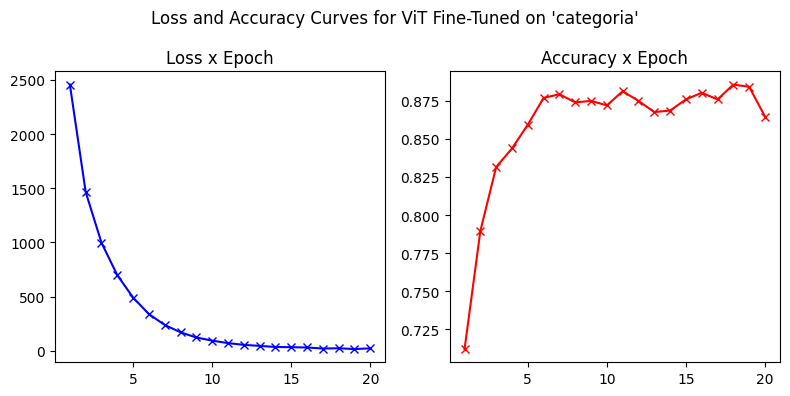

Validation accuracy: 0.8857421875
Validation average per class precision: 0.8841
Validation average per class recall: 0.8660

Test accuracy: 0.8803681135177612
Test average per class precision: 0.8782
Test average per class recall: 0.8569



Computing embeddings: 100%|█████████████████████████████████████████| 23/23 [02:42<00:00,  7.08s/it]
/home/lui/anaconda3/envs/ind_thesis/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [20]:
# Retraining model with augmented dataset to see the difference in the results
batch_size = 16
epochs = 20
num_classes = len(categoria_filtered_categories)
model = ViTClassifier(num_classes).to(device)
criterion = nn.CrossEntropyLoss(weight=categoria_class_weights)
opt = optim.Adam(model.parameters(), lr=3e-6, weight_decay=1e-6)
model_name = 'balanced_vit_categoria'
column_name = 'categoria'

execute_train_test(categoria_augmented_dataset, categoria_balanced_test_dataset, device, \
                   batch_size, epochs, num_classes, model, criterion, opt, model_name, \
                   column_name, categoria_balanced_val_dataset)

categoria_vit_trimap, categoria_vit_tsne, categoria_vit_umap, \
categoria_image_indices = compute_classifier_embeddings(categoria_dataloader, model, device)

# Cleaning up memory
clean_mem([model])

Training model:   5%|██▎                                          | 1/20 [09:03<2:51:59, 543.12s/it]

Best model saved at epoch 1
Epoch 1, Loss: 2668.1925, Validation Accuracy: 0.6421


Training model:  10%|████▌                                        | 2/20 [18:00<2:41:55, 539.75s/it]

Best model saved at epoch 2
Epoch 2, Loss: 1794.1300, Validation Accuracy: 0.7176


Training model:  15%|██████▊                                      | 3/20 [26:56<2:32:26, 538.02s/it]

Best model saved at epoch 3
Epoch 3, Loss: 1297.6466, Validation Accuracy: 0.7728


Training model:  20%|█████████                                    | 4/20 [35:51<2:23:11, 536.97s/it]

Best model saved at epoch 4
Epoch 4, Loss: 990.4755, Validation Accuracy: 0.8197


Training model:  25%|███████████▎                                 | 5/20 [44:44<2:13:53, 535.57s/it]

Best model saved at epoch 5
Epoch 5, Loss: 763.6864, Validation Accuracy: 0.8381


Training model:  30%|█████████████▌                               | 6/20 [53:45<2:05:19, 537.10s/it]

Best model saved at epoch 6
Epoch 6, Loss: 581.8617, Validation Accuracy: 0.8611


Training model:  35%|███████████████                            | 7/20 [1:02:46<1:56:41, 538.55s/it]

Best model saved at epoch 7
Epoch 7, Loss: 435.6989, Validation Accuracy: 0.8648


Training model:  40%|█████████████████▏                         | 8/20 [1:11:41<1:47:29, 537.43s/it]

Best model saved at epoch 8
Epoch 8, Loss: 316.1279, Validation Accuracy: 0.8712


Training model:  45%|███████████████████▎                       | 9/20 [1:20:43<1:38:48, 538.94s/it]

Best model saved at epoch 9
Epoch 9, Loss: 227.4353, Validation Accuracy: 0.8850


Training model:  50%|█████████████████████                     | 10/20 [1:29:32<1:29:16, 535.66s/it]

Epoch 10, Loss: 160.5012, Validation Accuracy: 0.8804


Training model:  55%|███████████████████████                   | 11/20 [1:38:29<1:20:26, 536.25s/it]

Best model saved at epoch 11
Epoch 11, Loss: 114.2996, Validation Accuracy: 0.8878


Training model:  60%|█████████████████████████▏                | 12/20 [1:47:22<1:11:21, 535.20s/it]

Epoch 12, Loss: 82.8850, Validation Accuracy: 0.8841


Training model:  65%|███████████████████████████▎              | 13/20 [1:56:15<1:02:22, 534.62s/it]

Best model saved at epoch 13
Epoch 13, Loss: 59.3401, Validation Accuracy: 0.8914


Training model:  70%|██████████████████████████████▊             | 14/20 [2:05:17<53:40, 536.75s/it]

Epoch 14, Loss: 43.5312, Validation Accuracy: 0.8868


Training model:  75%|█████████████████████████████████           | 15/20 [2:14:11<44:40, 536.07s/it]

Epoch 15, Loss: 33.1336, Validation Accuracy: 0.8859


Training model:  80%|███████████████████████████████████▏        | 16/20 [2:22:53<35:26, 531.62s/it]

Epoch 16, Loss: 25.0231, Validation Accuracy: 0.8896


Training model:  85%|█████████████████████████████████████▍      | 17/20 [2:31:36<26:27, 529.06s/it]

Epoch 17, Loss: 20.9802, Validation Accuracy: 0.8896


Training model:  90%|███████████████████████████████████████▌    | 18/20 [2:40:21<17:35, 528.00s/it]

Best model saved at epoch 18
Epoch 18, Loss: 14.4561, Validation Accuracy: 0.8933


Training model:  95%|█████████████████████████████████████████▊  | 19/20 [2:49:17<08:50, 530.38s/it]

Epoch 19, Loss: 12.3184, Validation Accuracy: 0.8914


Training model: 100%|████████████████████████████████████████████| 20/20 [2:57:59<00:00, 533.99s/it]


Epoch 20, Loss: 10.2033, Validation Accuracy: 0.8924


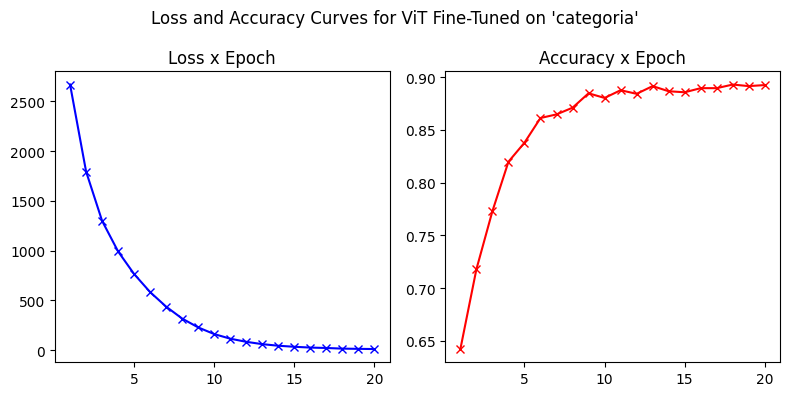

Validation accuracy: 0.89306640625
Validation average per class precision: 0.8896
Validation average per class recall: 0.8689



/home/lui/Documents/uva/thesis/tainacan_collection/image_based/image_training_utils.py:687: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('../data/mo

Test accuracy: 0.8711656332015991
Test average per class precision: 0.8787
Test average per class recall: 0.8462



In [21]:
# Training partially frozen model on balanced dataset to see the difference in results
batch_size = 16
epochs = 20
num_classes = len(categoria_filtered_categories)
freeze = 7
model = ViTClassifier(num_classes, freeze=freeze).to(device)
criterion = nn.CrossEntropyLoss(weight=categoria_class_weights)
opt = optim.Adam(model.parameters(), lr=3e-6, weight_decay=1e-6)
model_name = 'frozen_vit_categoria'
column_name = 'categoria'

execute_train_test(categoria_augmented_dataset, categoria_balanced_test_dataset, device, \
                   batch_size, epochs, num_classes, model, criterion, opt, model_name, \
                   column_name, categoria_balanced_val_dataset)

# Cleaning up memory
clean_mem([model])

#### Multi-Head Training

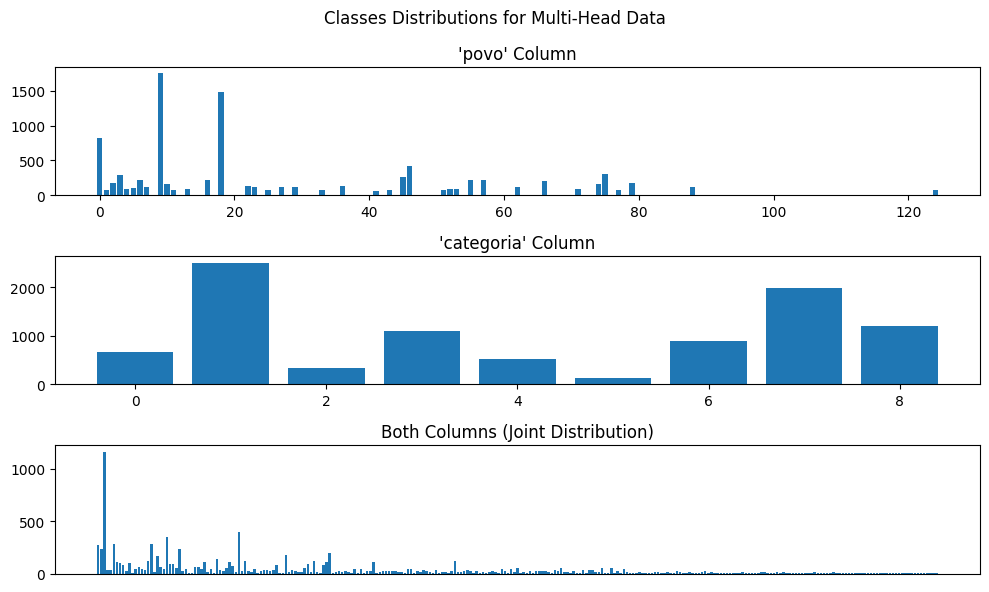

In [22]:
# Getting data that passes both heads' data-filters
povo_set = set(np.array(list(povo_labels.keys()))\
                [np.where(np.isin(np.array(list(povo_labels.values())), \
                np.array(list(povo_filtered_categories.keys()))))[0]])
categoria_set = set(np.array(list(categoria_labels.keys()))\
                    [np.where(np.isin(np.array(list(categoria_labels.values())), \
                    np.array(list(categoria_filtered_categories.keys()))))[0]])
multi_head_keys = [str(x) for x in povo_set.intersection(categoria_set)]

# Studying individual and joint classes' distributions
povo_freq = {}
categoria_freq = {}
multi_freq = {}
for key in multi_head_keys:
    try:
        povo_freq[povo_labels[key]] += 1
    except:
        povo_freq[povo_labels[key]] = 1

    try:
        categoria_freq[categoria_labels[key]] += 1
    except:
        categoria_freq[categoria_labels[key]] = 1

    try:
        multi_freq[f'{(povo_labels[key], categoria_labels[key])}'] += 1
    except:
        multi_freq[f'{(povo_labels[key], categoria_labels[key])}'] = 1

# Utility function to plot rows on data distribution plot
def row_bar_plot(col_freq, name, row, rows=3, cols=1, remove_xticks=False):
    plt.subplot(rows, cols, row)
    plt.bar(list(col_freq.keys()), list(col_freq.values()))
    plt.title(name)

    if remove_xticks:
        plt.xlabel("")
        plt.xticks([])

plt.figure(figsize=(10,6))
plt.suptitle('Classes Distributions for Multi-Head Data')

row_bar_plot(povo_freq, "'povo' Column", 1)
row_bar_plot(categoria_freq, "'categoria' Column", 2)
row_bar_plot(multi_freq, "Both Columns (Joint Distribution)", 3, remove_xticks=True)

plt.tight_layout()
plt.show()

In [23]:
# Because of the even worse degree of unbalanced data on the joint distribution, we balance
# the dataset taking the 'povo' column into consideration and study the new joint distribution
multi_povo_labels = {}
multi_categoria_labels = {}
for key in multi_head_keys:
    multi_povo_labels[key] = povo_labels[key]
    multi_categoria_labels[key] = categoria_labels[key]

# Reusing previous dataset infrastructure to build multi-label dataset
multi_povo_categories, categories_keys, categories_freq, \
qs, masks = study_class_distribution(multi_povo_labels)
multi_povo_filtered_categories = multi_povo_categories
multi_povo_filtered_categories_names = {}
for c in categories_keys:
    multi_povo_filtered_categories_names[povo_num_to_name[c]] = multi_povo_categories[c]

multi_categoria_categories, categories_keys, categories_freq, \
qs, masks = study_class_distribution(multi_categoria_labels)
multi_categoria_filtered_categories = multi_categoria_categories
multi_categoria_filtered_categories_names = {}
for c in categories_keys:
    multi_categoria_filtered_categories_names[categoria_num_to_name[c]] = \
    multi_categoria_categories[c]

Quantile X Data Percentage:
Q-10: 75.00, 96.14% of data
Q-25: 86.00, 91.77% of data
Q-50: 123.00, 80.30% of data
Q-75: 216.50, 64.05% of data
Q-90: 327.40, 47.86% of data

Quantile X Data Percentage:
Q-10: 302.40, 98.63% of data
Q-25: 515.00, 89.42% of data
Q-50: 887.00, 72.71% of data
Q-75: 1203.00, 48.06% of data
Q-90: 2089.00, 26.84% of data



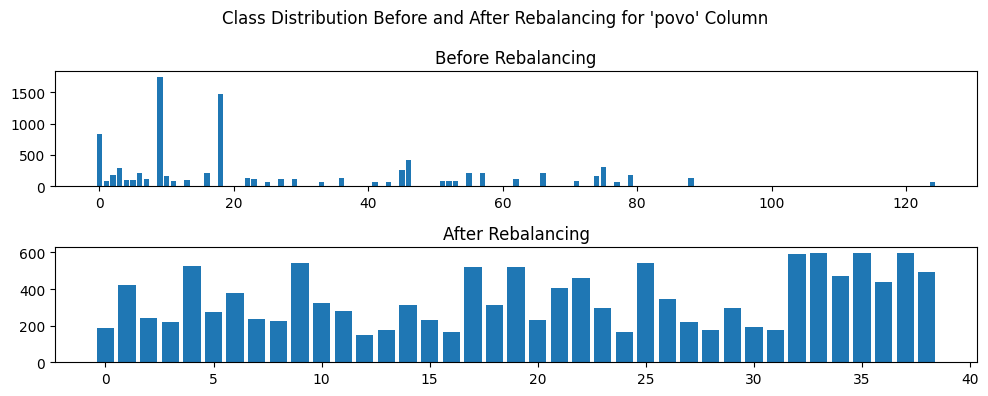

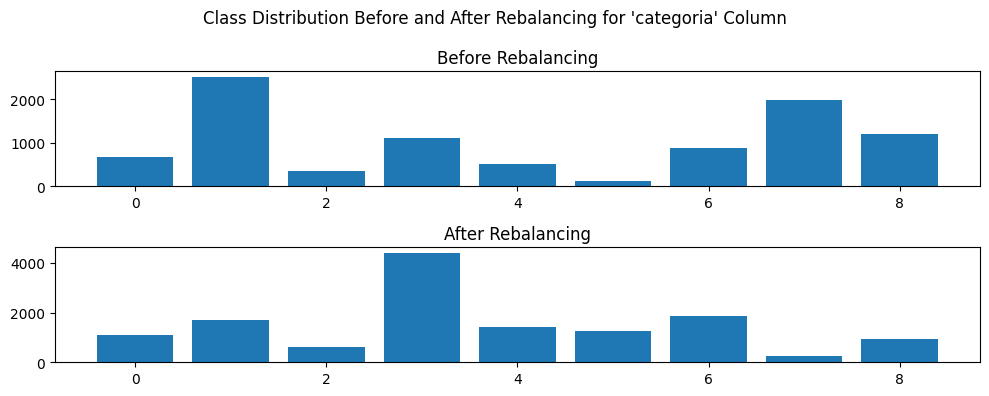

In [24]:
# Filtering dataframe for selected categories
threshold_multiplier = 2
minority_classes, majority_classes, labels_minority, labels_majority, \
val_labels, test_labels, multi_augmented_dataset, multi_balanced_val_dataset, \
multi_balanced_test_dataset = \
multihead_filter_image_data_distribution(ind_df, [multi_povo_filtered_categories_names, \
                                         multi_categoria_filtered_categories_names], \
                                         vit_transform, threshold_multiplier, \
                                         ['povo', 'categoria'])

# Plotting old and new class distributions
multihead_plot_class_distributions(multi_povo_categories, multi_povo_filtered_categories, \
                                   labels_minority, labels_majority, threshold_multiplier, \
                                   'povo')

multihead_plot_class_distributions(multi_categoria_categories, \
                                   multi_categoria_filtered_categories, \
                                   labels_minority, labels_majority, threshold_multiplier, \
                                   'categoria')

In [25]:
# Because the dataset is still unbalanced, we also create class weights for the loss function
multi_povo_class_weights = multihead_compute_class_weights(multi_povo_filtered_categories, \
                                                           labels_minority, labels_majority, \
                                                           device, threshold_multiplier, \
                                                           'povo')

multi_categoria_class_weights = \
multihead_compute_class_weights(multi_categoria_filtered_categories, labels_minority, \
                                labels_majority, device, threshold_multiplier,'categoria')

Training model:   3%|█▌                                           | 1/30 [07:03<3:24:40, 423.47s/it]

Best model saved at epoch 1
Epoch 1, Combined Loss: 1731.0499, Validation Average Accuracy: 0.5010


Training model:   7%|███                                          | 2/30 [14:00<3:15:47, 419.55s/it]

Best model saved at epoch 2
Epoch 2, Combined Loss: 1209.5737, Validation Average Accuracy: 0.5605


Training model:  10%|████▌                                        | 3/30 [20:54<3:07:43, 417.16s/it]

Best model saved at epoch 3
Epoch 3, Combined Loss: 977.9901, Validation Average Accuracy: 0.5923


Training model:  13%|██████                                       | 4/30 [27:44<2:59:32, 414.33s/it]

Best model saved at epoch 4
Epoch 4, Combined Loss: 849.7140, Validation Average Accuracy: 0.5967


Training model:  17%|███████▌                                     | 5/30 [34:40<2:52:50, 414.83s/it]

Best model saved at epoch 5
Epoch 5, Combined Loss: 762.2829, Validation Average Accuracy: 0.6201


Training model:  20%|█████████                                    | 6/30 [41:42<2:46:57, 417.39s/it]

Best model saved at epoch 6
Epoch 6, Combined Loss: 682.8364, Validation Average Accuracy: 0.6455


Training model:  23%|██████████▌                                  | 7/30 [48:37<2:39:43, 416.69s/it]

Best model saved at epoch 7
Epoch 7, Combined Loss: 603.2302, Validation Average Accuracy: 0.6860


Training model:  27%|████████████                                 | 8/30 [55:28<2:32:03, 414.70s/it]

Best model saved at epoch 8
Epoch 8, Combined Loss: 519.8623, Validation Average Accuracy: 0.7021


Training model:  30%|████████████▉                              | 9/30 [1:02:24<2:25:19, 415.21s/it]

Best model saved at epoch 9
Epoch 9, Combined Loss: 438.5155, Validation Average Accuracy: 0.7422


Training model:  33%|██████████████                            | 10/30 [1:09:29<2:19:23, 418.20s/it]

Best model saved at epoch 10
Epoch 10, Combined Loss: 355.1411, Validation Average Accuracy: 0.7559


Training model:  37%|███████████████▍                          | 11/30 [1:16:25<2:12:11, 417.45s/it]

Best model saved at epoch 11
Epoch 11, Combined Loss: 280.9021, Validation Average Accuracy: 0.7744


Training model:  40%|████████████████▊                         | 12/30 [1:23:20<2:05:00, 416.70s/it]

Best model saved at epoch 12
Epoch 12, Combined Loss: 216.5316, Validation Average Accuracy: 0.7773


Training model:  43%|██████████████████▏                       | 13/30 [1:30:14<1:57:49, 415.83s/it]

Best model saved at epoch 13
Epoch 13, Combined Loss: 160.3537, Validation Average Accuracy: 0.7812


Training model:  47%|███████████████████▌                      | 14/30 [1:37:11<1:51:01, 416.31s/it]

Best model saved at epoch 14
Epoch 14, Combined Loss: 117.3224, Validation Average Accuracy: 0.7891


Training model:  50%|█████████████████████                     | 15/30 [1:44:08<1:44:06, 416.44s/it]

Best model saved at epoch 15
Epoch 15, Combined Loss: 82.4763, Validation Average Accuracy: 0.8052


Training model:  53%|██████████████████████▍                   | 16/30 [1:51:01<1:36:58, 415.58s/it]

Epoch 16, Combined Loss: 60.3259, Validation Average Accuracy: 0.7925


Training model:  57%|███████████████████████▊                  | 17/30 [1:57:53<1:29:48, 414.47s/it]

Epoch 17, Combined Loss: 48.3446, Validation Average Accuracy: 0.7925


Training model:  60%|█████████████████████████▏                | 18/30 [2:04:43<1:22:37, 413.14s/it]

Epoch 18, Combined Loss: 30.7213, Validation Average Accuracy: 0.8013


Training model:  60%|█████████████████████████▏                | 18/30 [2:11:46<1:27:51, 439.27s/it]


Early-stopping training!


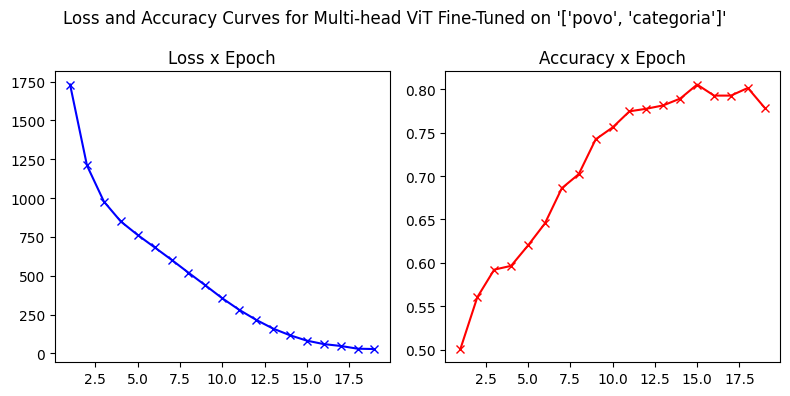

Validation 'povo' head accuracy: 0.71435546875
Validation 'categoria' head accuracy: 0.89599609375
Validation average accuracy: 0.80517578125

Validation 'povo' head average per class precision: 0.7003
Validation 'povo' head average per class recall: 0.6759

Validation 'categoria' head average per class precision: 0.8893
Validation 'categoria' head average per class recall: 0.8632



/home/lui/Documents/uva/thesis/tainacan_collection/image_based/image_training_utils.py:719: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('../data/mo

Test 'povo' head accuracy: 0.6882662177085876
Test 'categoria' head accuracy: 0.8791593909263611
Test average accuracy: 0.78369140625

Test 'povo' head average per class precision: 0.6816
Test 'povo' head average per class recall: 0.6634

Test 'categoria' head average per class precision: 0.8766
Test 'categoria' head average per class recall: 0.8549



Computing embeddings: 100%|█████████████████████████████████████████| 23/23 [03:05<00:00,  8.06s/it]
/home/lui/anaconda3/envs/ind_thesis/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [26]:
# Training multi-head model on balanced dataset to see the difference in results
batch_size = 16
epochs = 30
num_classes = [len(multi_povo_filtered_categories), len(multi_categoria_filtered_categories)]
model = ViTClassifier(num_classes[0], num_classes[1]).to(device)
criterions = [nn.CrossEntropyLoss(weight=multi_povo_class_weights), \
              nn.CrossEntropyLoss(weight=multi_categoria_class_weights)]
opt = optim.Adam(model.parameters(), lr=1e-5, weight_decay=3e-6)
model_name = 'multihead_vit'
column_names = ['povo', 'categoria']
arch_name = 'ViT'
head_weights = [0.3, 0.7]

multihead_execute_train_test(multi_augmented_dataset, multi_balanced_test_dataset, device, \
                             batch_size, epochs, num_classes, model, \
                             criterions, opt, model_name, column_names, \
                             multi_balanced_val_dataset, arch_name, head_weights)

multihead_vit_trimap, multihead_vit_tsne, multihead_vit_umap, \
multihead_image_indices = compute_classifier_embeddings(categoria_dataloader, model, device)

# Cleaning up memory
clean_mem([model])

### Visualizing and Comparing Projections

In [27]:
# Normalizing data for later plot on tool
norm_factor = 12
vanilla_vit_trimap = normalize(vanilla_vit_trimap, norm_factor)
vanilla_vit_tsne = normalize(vanilla_vit_tsne, norm_factor)
vanilla_vit_umap = normalize(vanilla_vit_umap, norm_factor)

povo_vit_trimap = normalize(povo_vit_trimap, norm_factor)
povo_vit_tsne = normalize(povo_vit_tsne, norm_factor)
povo_vit_umap = normalize(povo_vit_umap, norm_factor)

categoria_vit_trimap = normalize(categoria_vit_trimap, norm_factor)
categoria_vit_tsne = normalize(categoria_vit_tsne, norm_factor)
categoria_vit_umap = normalize(categoria_vit_umap, norm_factor)

multihead_vit_trimap = normalize(multihead_vit_trimap, norm_factor)
multihead_vit_tsne = normalize(multihead_vit_tsne, norm_factor)
multihead_vit_umap = normalize(multihead_vit_umap, norm_factor)

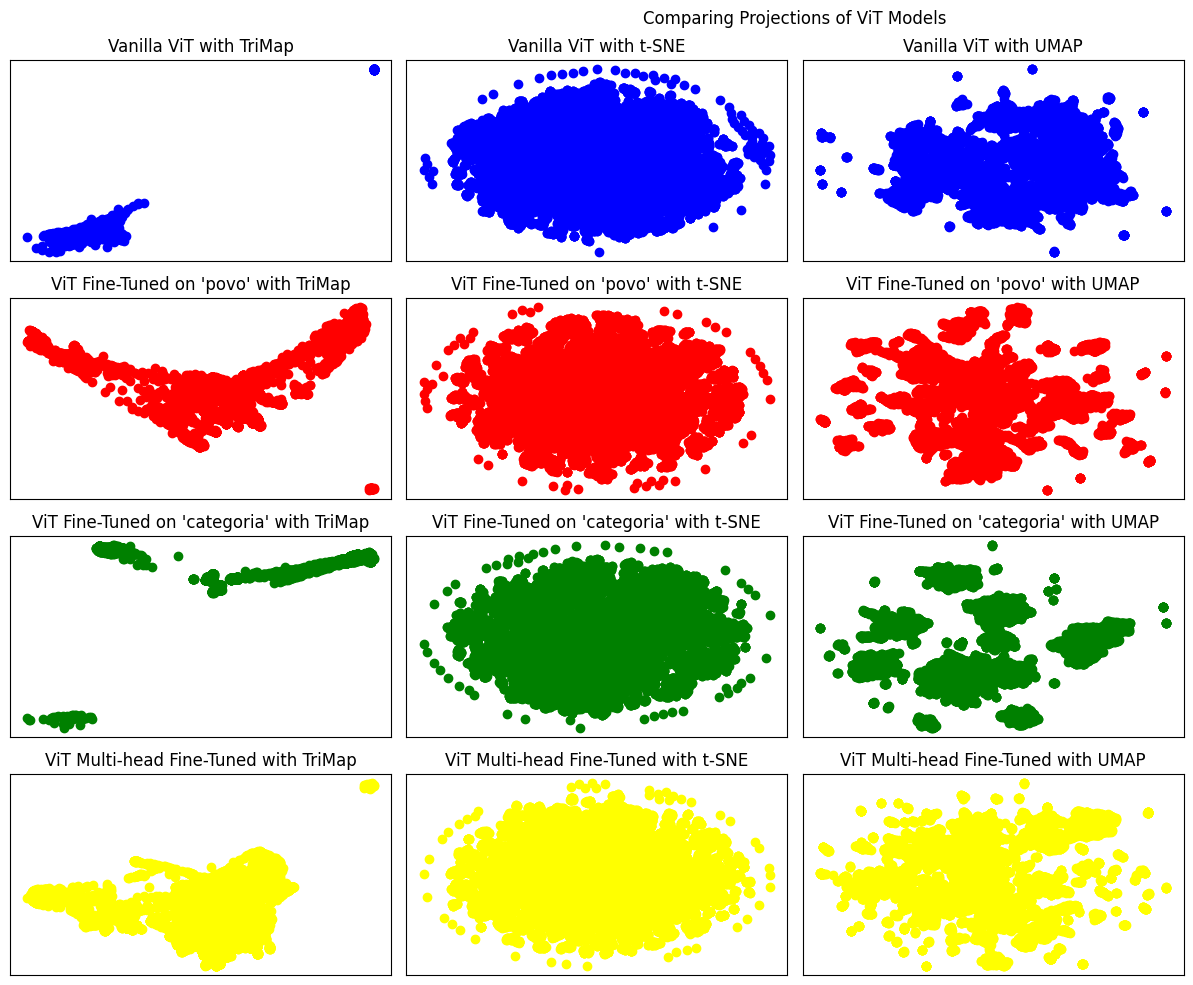

In [28]:
# Utility function to plot rows on projection comparison plot
def row_scatter_plot(projs, proj_names, row, color, rows=4, cols=4):
    for i, (proj, proj_name) in enumerate(zip(projs, proj_names)):
        plt.subplot(rows, cols, i+1+(cols*(row-1)))
        plt.scatter(proj[:, 0], proj[:, 1], c=color)
        plt.title(f"{proj_name}")
        plt.xlabel("")
        plt.ylabel("")
        plt.xticks([])
        plt.yticks([])

# Visualizing resulting projections
plt.figure(figsize=(16,10))
plt.suptitle('Comparing Projections of ViT Models')

# Plotting vanilla ViT projections
projs = [vanilla_vit_trimap, vanilla_vit_tsne, vanilla_vit_umap]
proj_names = ['Vanilla ViT with TriMap', 'Vanilla ViT with t-SNE', 'Vanilla ViT with UMAP']
row_scatter_plot(projs, proj_names, 1, 'b')

# Plotting ViT fine-tuned on 'povo' projections
projs = [povo_vit_trimap, povo_vit_tsne, povo_vit_umap]
proj_names = ["ViT Fine-Tuned on 'povo' with TriMap", "ViT Fine-Tuned on 'povo' with t-SNE", \
              "ViT Fine-Tuned on 'povo' with UMAP"]
row_scatter_plot(projs, proj_names, 2, 'r')

# Plotting ViT fine-tuned on 'categoria' projections
projs = [categoria_vit_trimap, categoria_vit_tsne, categoria_vit_umap]
proj_names = ["ViT Fine-Tuned on 'categoria' with TriMap", \
              "ViT Fine-Tuned on 'categoria' with t-SNE", \
              "ViT Fine-Tuned on 'categoria' with UMAP"]
row_scatter_plot(projs, proj_names, 3, 'g')

# Plotting ViT fine-tuned on 'povo' and 'categoria' (multi-head) projections
projs = [multihead_vit_trimap, multihead_vit_tsne, multihead_vit_umap]
proj_names = ["ViT Multi-head Fine-Tuned with TriMap", \
              "ViT Multi-head Fine-Tuned with t-SNE", \
              "ViT Multi-head Fine-Tuned with UMAP"]
row_scatter_plot(projs, proj_names, 4, 'yellow')

plt.tight_layout()
plt.show()

### Visualizing Clusters

/home/lui/Documents/uva/thesis/tainacan_collection/image_based/image_training_utils.py:818: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


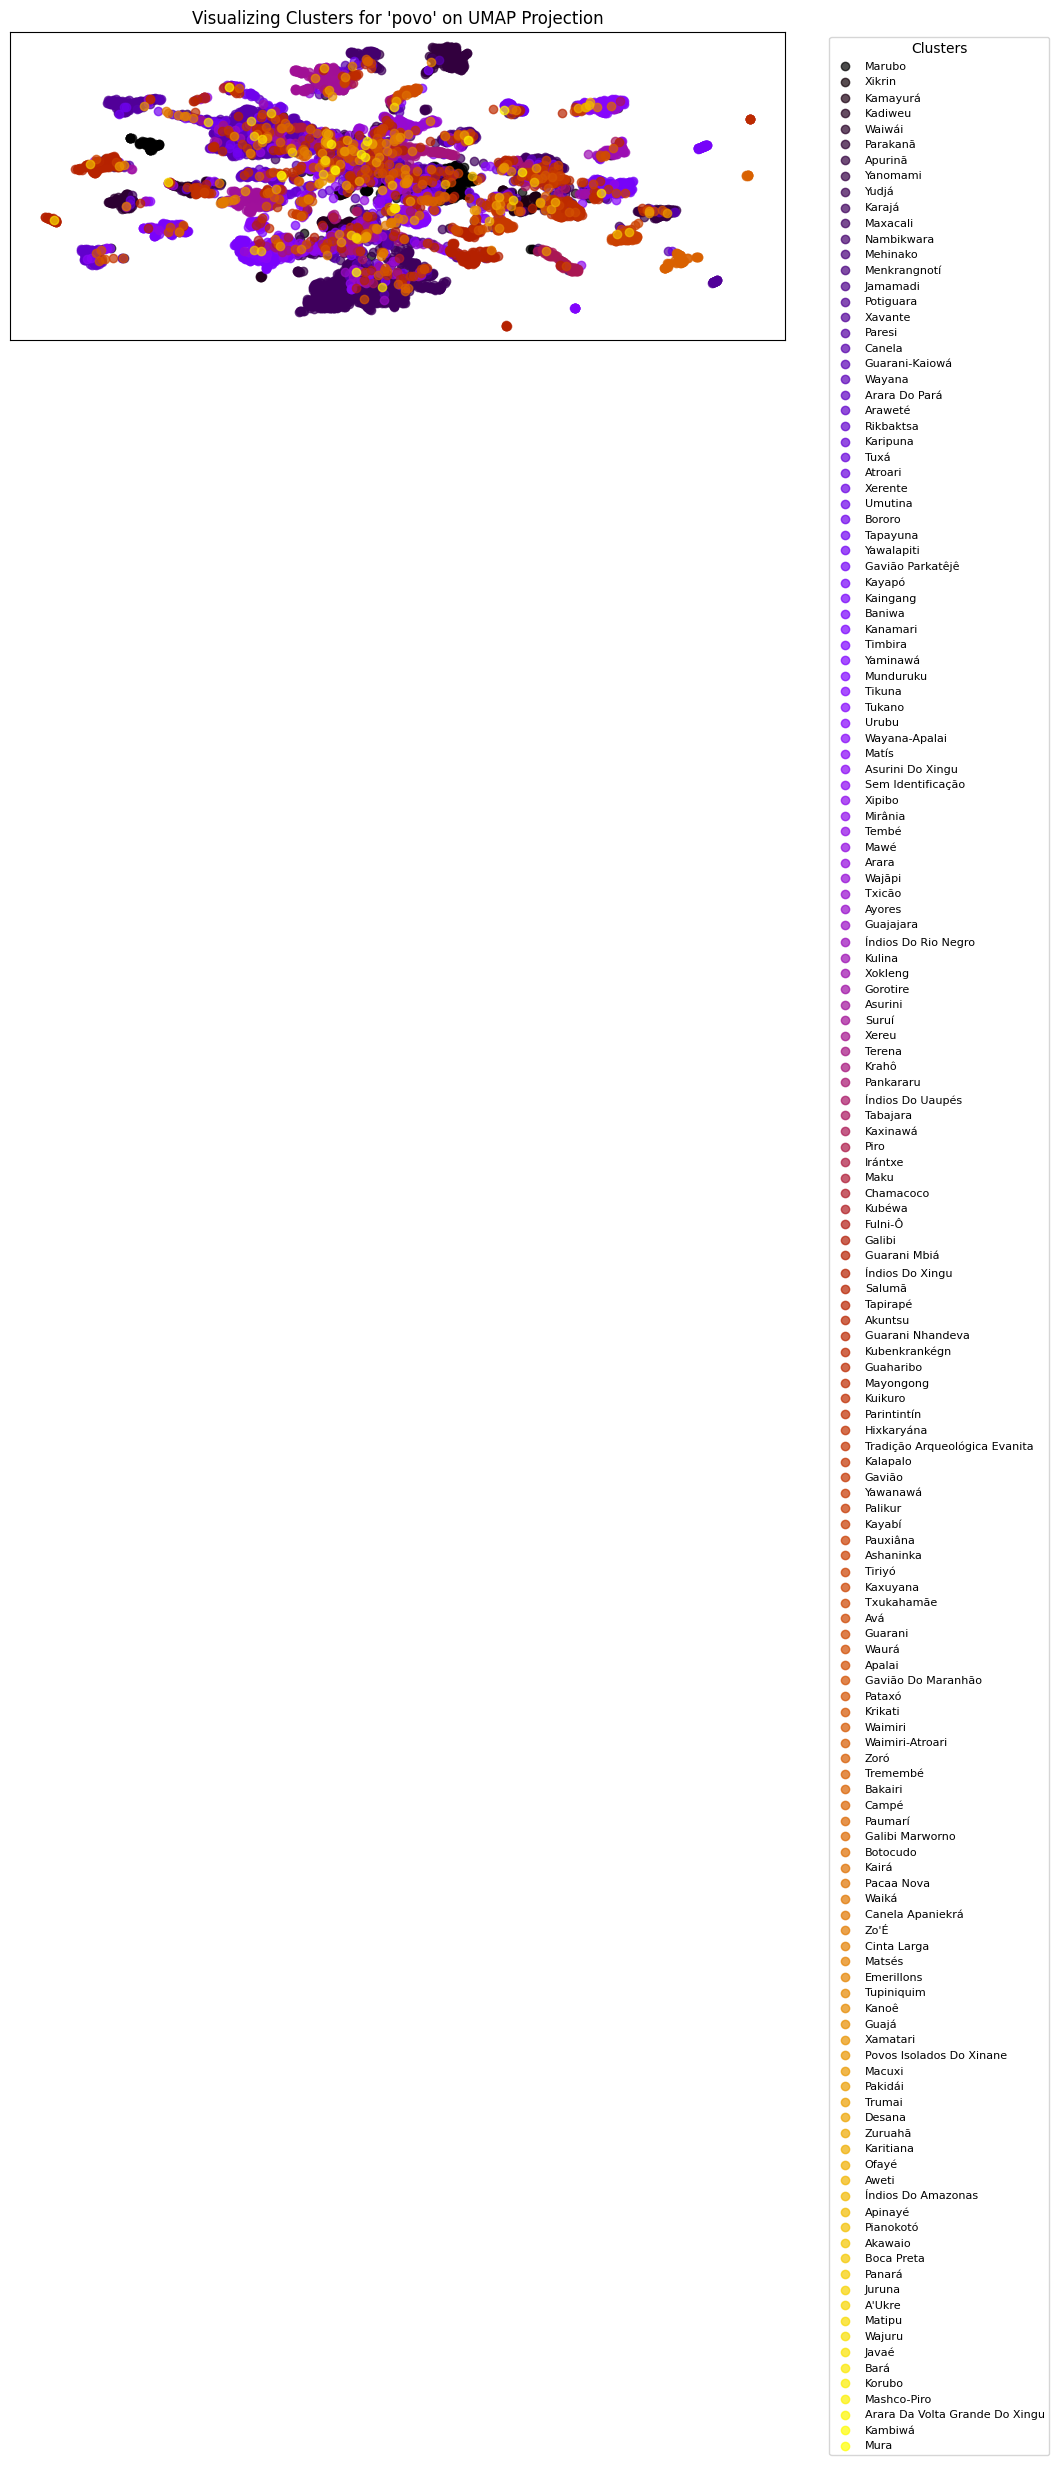

In [29]:
# Filtering dataframe to get only the part that contains images
filtered_df = ind_df.loc[ind_df['image_path'].notna()]

# Visualizing 'povo' cluster
visualizing_clusters(filtered_df, povo_vit_umap, povo_image_indices, 'povo', 'UMAP')

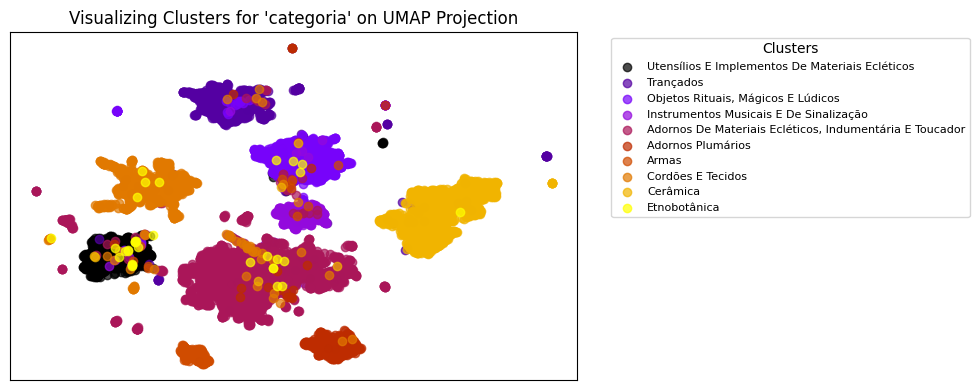

In [30]:
# Visualizing 'categoria' cluster
visualizing_clusters(filtered_df, categoria_vit_umap, categoria_image_indices, \
                     'categoria', 'UMAP')

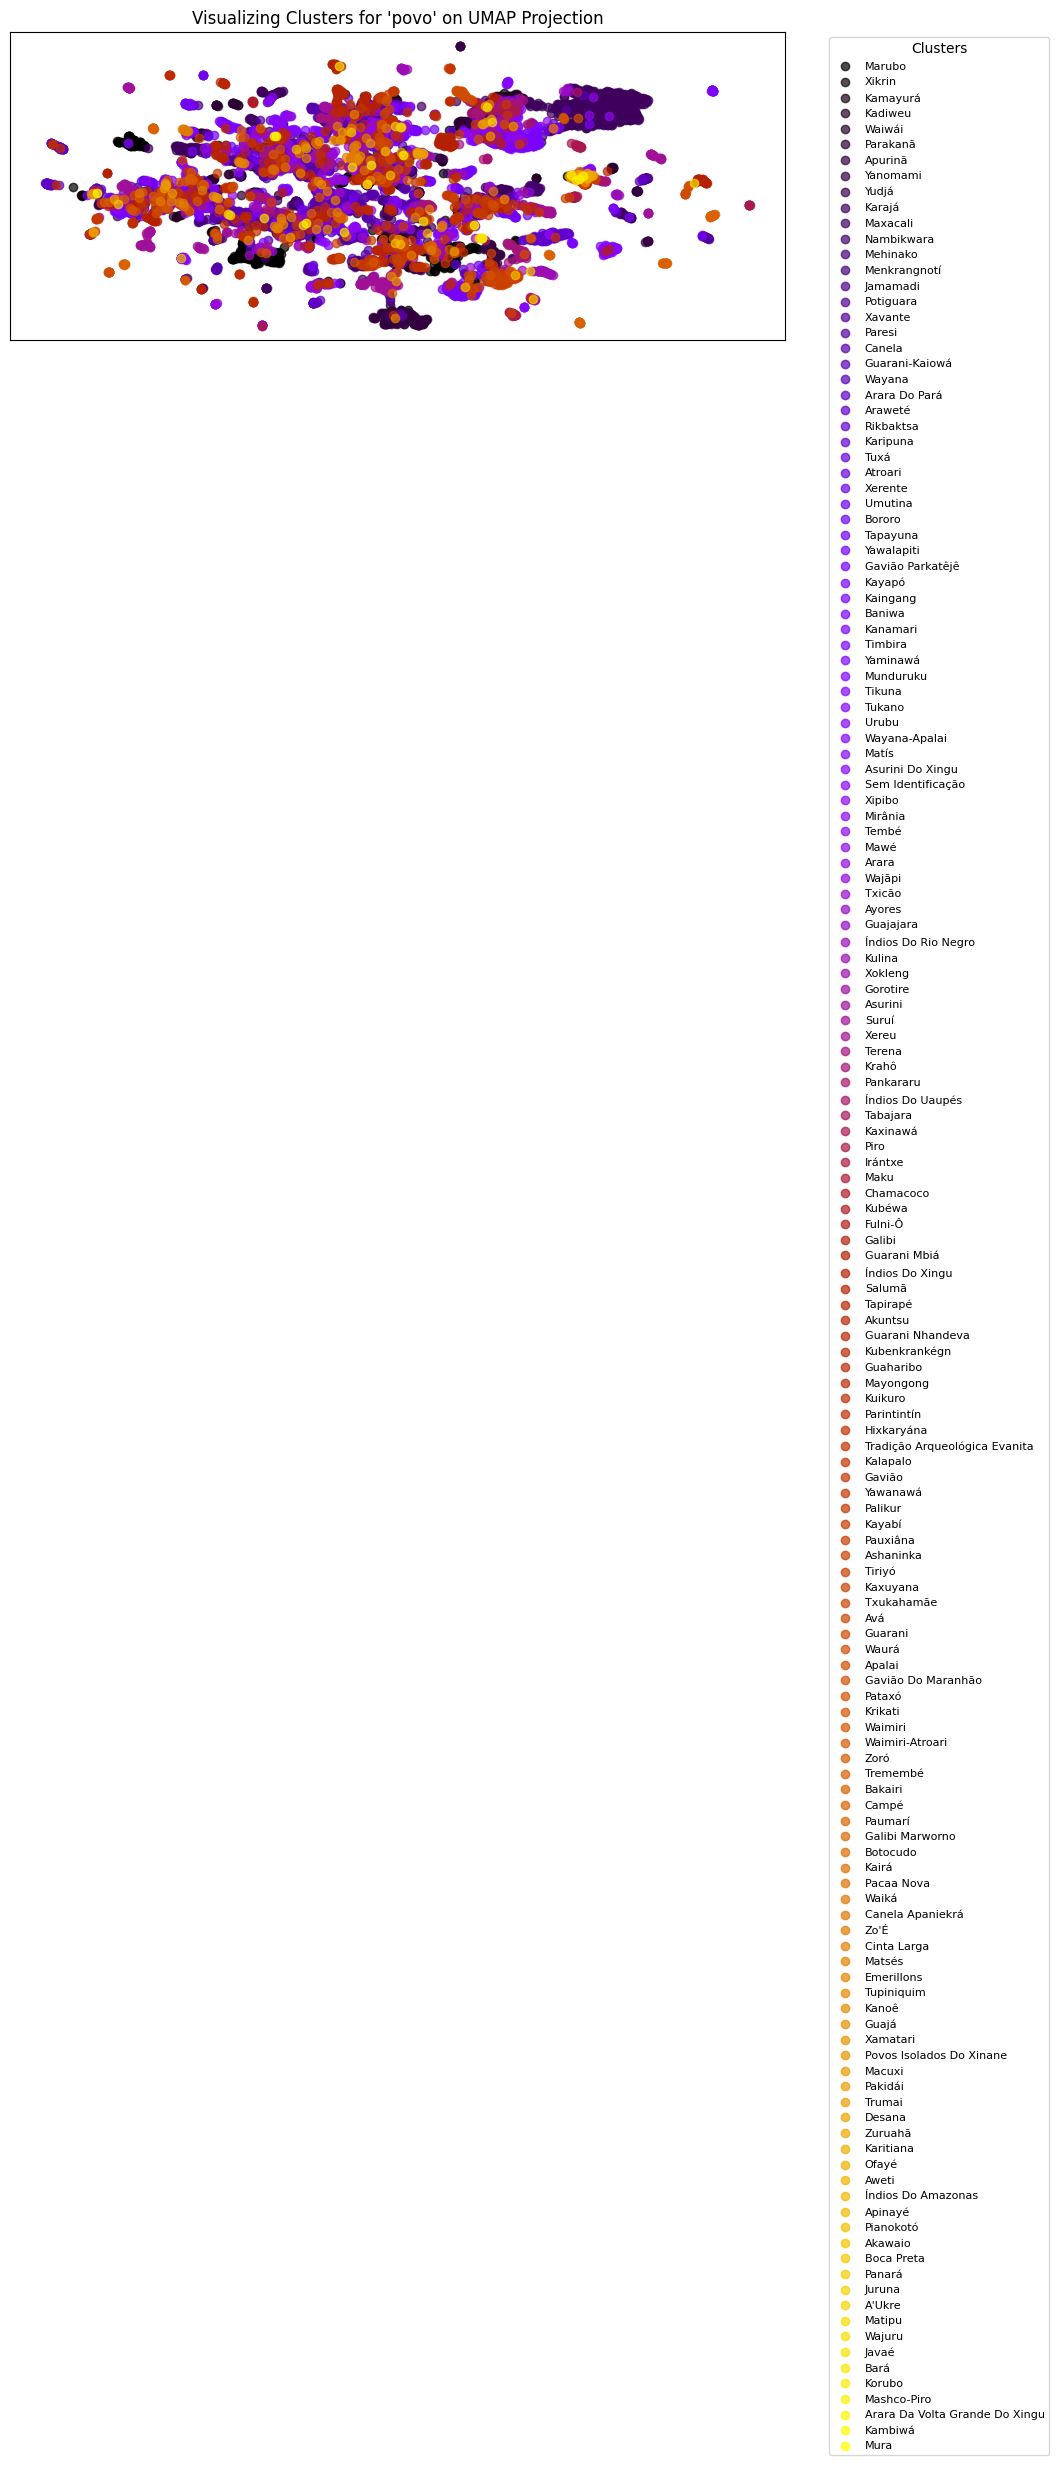

In [31]:
# Visualizing 'povo' cluster for multi-head modedl
visualizing_clusters(filtered_df, multihead_vit_umap, multihead_image_indices, \
                     'povo', 'UMAP')

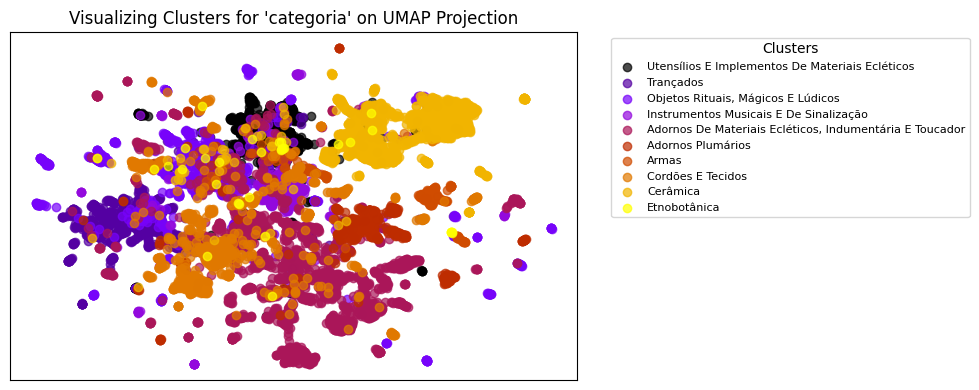

In [32]:
# Visualizing 'categoria' cluster for multi-head modedl
visualizing_clusters(filtered_df, multihead_vit_umap, multihead_image_indices, \
                     'categoria', 'UMAP')

In [33]:
# Saving outputs for visualization tool
_ = saving_outputs(filtered_df, povo_labels, vanilla_vit_umap, vanilla_image_indices, \
                   save_file='vanilla_vit.csv', no_clusters=True)

_ = saving_outputs(filtered_df, povo_labels, povo_vit_umap, povo_image_indices, 'povo', \
                   'povo_vit.csv')

_ = saving_outputs(filtered_df, categoria_labels, categoria_vit_umap, \
                   categoria_image_indices, 'categoria', 'categoria_vit.csv')

_ = saving_outputs(filtered_df, povo_labels, multihead_vit_umap, \
                   multihead_image_indices, save_file='multihead_vit.csv', no_clusters=True)

## DINOv2

### Pre-Trained Embedding Space

In [34]:
from transformers import AutoImageProcessor, AutoModel

# Rebuilding dataset with DINO transform and dataloader with smaller batch_size because of 
# the model's size
dino_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(256, interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.CenterCrop((224, 224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
povo_dataset = ImageDataset(povo_labels, transform=dino_transform, augment=False)
povo_dataloader = DataLoader(povo_dataset, batch_size=16, shuffle=True, \
                             num_workers=0, pin_memory=True)

# Loading model and pre-processor
dino_processor = AutoImageProcessor.from_pretrained('facebook/dinov2-base')
model = AutoModel.from_pretrained('facebook/dinov2-base')
model.to(device)

# Projecting data onto the off-the-shelf pre-trained embedding space from DINOv2
image_embeddings, vanilla_image_indices = get_embeddings(model, povo_dataloader, device, \
                                                         model_name='dino')
image_embeddings = np.concatenate(image_embeddings, axis=0)
vanilla_image_indices = np.concatenate(vanilla_image_indices, axis=0)

# Computing data reduced-dimensionality projections
_, _, vanilla_dino_umap = data_projections(image_embeddings)

# Cleaning up memory
clean_mem([model, image_embeddings])

Computing embeddings: 100%|███████████████████████████████████████| 705/705 [03:18<00:00,  3.56it/s]
/home/lui/anaconda3/envs/ind_thesis/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


### Fine-Tuning Embedding Space

In [35]:
# Creating our own DINO classifier head for fine-tuning
class DINOClassifier(nn.Module):
    def __init__(self, num_classes1, num_classes2=0, freeze=0):
        super(DINOClassifier, self).__init__()
        self.dino = AutoModel.from_pretrained('facebook/dinov2-base')
        self.classifier1 = nn.Linear(self.dino.config.hidden_size, num_classes1)
        self.multi_head = False
        
        # Multi-head architecture
        if num_classes2 > 0:
            self.classifier2 = nn.Linear(self.dino.config.hidden_size, num_classes2)
            self.multi_head = True
        
        self.freeze_layers(freeze)
    
    def forward(self, x):
        outputs = self.dino(x)
        
        # Getting embeddings from last_hidden_state of CLS token (maybe pooler_output?)
        embeddings = outputs['last_hidden_state'][:, 0, :]
        # embeddings = outputs['pooler_output']

        logits1 = self.classifier1(embeddings)
        if self.multi_head:
            logits2 = self.classifier2(embeddings)
            return logits1, logits2
        return logits1

    # Freezing early layers so we don't lose generalization and speed up training
    def freeze_layers(self, freeze):
        if freeze <= 0:
            return

        # Accounting for the embedding freeze
        freeze -= 1
        
        for name, param in self.dino.named_parameters():
            if "embeddings" in name:
                param.requires_grad = False
            elif int(name.split('.')[2]) < freeze:
                param.requires_grad = False
            else:
                break

#### *povo* Column

Training model:   5%|██▎                                          | 1/20 [05:27<1:43:42, 327.48s/it]

Best model saved at epoch 1
Epoch 1, Loss: 1985.7519, Validation Accuracy: 0.3685


Training model:  10%|████▌                                        | 2/20 [10:51<1:37:36, 325.37s/it]

Best model saved at epoch 2
Epoch 2, Loss: 1441.1249, Validation Accuracy: 0.4414


Training model:  15%|██████▊                                      | 3/20 [16:13<1:31:45, 323.85s/it]

Best model saved at epoch 3
Epoch 3, Loss: 1138.7012, Validation Accuracy: 0.4877


Training model:  20%|█████████                                    | 4/20 [21:32<1:25:48, 321.81s/it]

Best model saved at epoch 4
Epoch 4, Loss: 886.6341, Validation Accuracy: 0.5281


Training model:  25%|███████████▎                                 | 5/20 [26:57<1:20:46, 323.09s/it]

Best model saved at epoch 5
Epoch 5, Loss: 667.7834, Validation Accuracy: 0.5448


Training model:  30%|█████████████▌                               | 6/20 [32:20<1:15:23, 323.12s/it]

Best model saved at epoch 6
Epoch 6, Loss: 482.2154, Validation Accuracy: 0.5576


Training model:  35%|███████████████▋                             | 7/20 [37:44<1:10:04, 323.42s/it]

Best model saved at epoch 7
Epoch 7, Loss: 335.0502, Validation Accuracy: 0.5734


Training model:  40%|██████████████████                           | 8/20 [43:08<1:04:41, 323.46s/it]

Best model saved at epoch 8
Epoch 8, Loss: 223.5213, Validation Accuracy: 0.5911


Training model:  45%|█████████████████████▏                         | 9/20 [48:32<59:22, 323.87s/it]

Epoch 9, Loss: 143.7369, Validation Accuracy: 0.5842


Training model:  50%|███████████████████████                       | 10/20 [54:00<54:08, 324.89s/it]

Epoch 10, Loss: 91.1214, Validation Accuracy: 0.5872


Training model:  55%|█████████████████████████▎                    | 11/20 [59:23<48:39, 324.39s/it]

Epoch 11, Loss: 58.5528, Validation Accuracy: 0.5833


Training model:  60%|██████████████████████████▍                 | 12/20 [1:04:43<43:03, 322.93s/it]

Epoch 12, Loss: 40.2661, Validation Accuracy: 0.5911


Training model:  65%|████████████████████████████▌               | 13/20 [1:10:04<37:37, 322.47s/it]

Best model saved at epoch 13
Epoch 13, Loss: 28.8931, Validation Accuracy: 0.5921


Training model:  70%|██████████████████████████████▊             | 14/20 [1:15:26<32:14, 322.43s/it]

Epoch 14, Loss: 20.9203, Validation Accuracy: 0.5892


Training model:  75%|█████████████████████████████████           | 15/20 [1:20:49<26:52, 322.59s/it]

Best model saved at epoch 15
Epoch 15, Loss: 16.4367, Validation Accuracy: 0.5941


Training model:  80%|███████████████████████████████████▏        | 16/20 [1:26:02<21:18, 319.64s/it]

Best model saved at epoch 16
Epoch 16, Loss: 12.6821, Validation Accuracy: 0.6010


Training model:  85%|█████████████████████████████████████▍      | 17/20 [1:31:29<16:05, 321.92s/it]

Epoch 17, Loss: 11.5708, Validation Accuracy: 0.5882


Training model:  90%|███████████████████████████████████████▌    | 18/20 [1:36:55<10:46, 323.20s/it]

Epoch 18, Loss: 9.5756, Validation Accuracy: 0.5911


Training model:  95%|█████████████████████████████████████████▊  | 19/20 [1:42:21<05:23, 323.89s/it]

Best model saved at epoch 19
Epoch 19, Loss: 11.4619, Validation Accuracy: 0.6039


Training model: 100%|████████████████████████████████████████████| 20/20 [1:47:49<00:00, 323.48s/it]


Best model saved at epoch 20
Epoch 20, Loss: 8.2171, Validation Accuracy: 0.6049


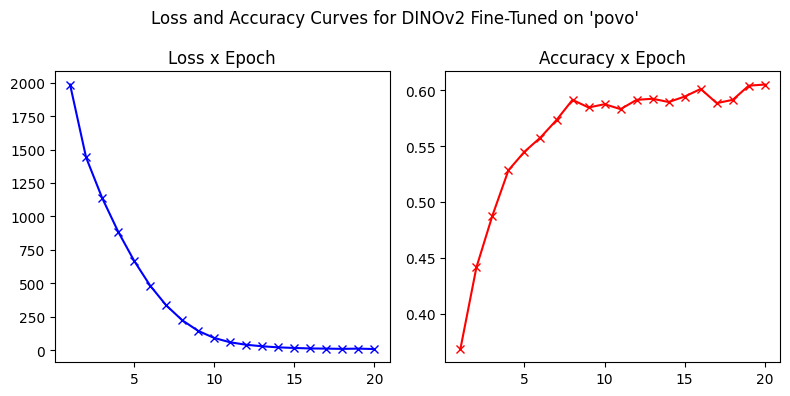

Validation accuracy: 0.60498046875
Validation average per class precision: 0.2337
Validation average per class recall: 0.2024



/home/lui/Documents/uva/thesis/tainacan_collection/image_based/image_training_utils.py:687: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('../data/mo

Test accuracy: 0.636202335357666
Test average per class precision: 0.2290
Test average per class recall: 0.1925

Test average precision on filtered classes: 0.5680667861149862
Test average recall on filtered classes: 0.5222540369782692


In [36]:
# Recreating datasets for proper training and testing
povo_train_val_dataset = ImageDataset(povo_train_val_labels, transform=dino_transform, \
                                      augment=False)
povo_test_dataset = ImageDataset(povo_test_labels, transform=dino_transform, augment=False)

# Setting-up training, executing training and then running tests
batch_size = 16
epochs = 20
num_classes = ind_df['povo'].dropna().nunique()
model = DINOClassifier(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters(), lr=1e-6, weight_decay=3e-7)
model_name = 'dino_povo'
column_name = 'povo'

test_prec, test_rec = execute_train_test(povo_train_val_dataset, povo_test_dataset, device, \
                                        batch_size, epochs, num_classes, model, criterion, \
                                        opt, model_name, column_name, \
                                        architecture_name='DINOv2')
prec_rec_on_selected_classes(povo_categories, povo_filtered_categories, test_prec, test_rec)

# Cleaning up memory
clean_mem([model])

In [37]:
# Filtering dataframe for selected categories. We need to recompute this part of the dataset
# because of the different transform used
threshold_multiplier = 2
minority_classes, majority_classes, labels_minority, labels_majority, \
val_labels, test_labels, povo_augmented_dataset, povo_balanced_val_dataset, \
povo_balanced_test_dataset = filter_image_data_distribution(ind_df, \
                                                            povo_filtered_categories_names, \
                                                            dino_transform, \
                                                            threshold_multiplier, \
                                                            'povo')

Training model:   5%|██▎                                          | 1/20 [09:09<2:54:05, 549.76s/it]

Best model saved at epoch 1
Epoch 1, Loss: 2423.9913, Validation Accuracy: 0.4351


Training model:  10%|████▌                                        | 2/20 [17:58<2:41:10, 537.25s/it]

Best model saved at epoch 2
Epoch 2, Loss: 1366.3728, Validation Accuracy: 0.5759


Training model:  15%|██████▊                                      | 3/20 [27:17<2:35:04, 547.33s/it]

Best model saved at epoch 3
Epoch 3, Loss: 847.2365, Validation Accuracy: 0.6135


Training model:  20%|█████████                                    | 4/20 [36:37<2:27:15, 552.24s/it]

Best model saved at epoch 4
Epoch 4, Loss: 533.8603, Validation Accuracy: 0.6307


Training model:  25%|███████████▎                                 | 5/20 [45:57<2:18:45, 555.05s/it]

Best model saved at epoch 5
Epoch 5, Loss: 332.5918, Validation Accuracy: 0.6729


Training model:  30%|█████████████▌                               | 6/20 [55:08<2:09:10, 553.64s/it]

Epoch 6, Loss: 210.1758, Validation Accuracy: 0.6729


Training model:  35%|███████████████                            | 7/20 [1:04:22<2:00:01, 553.98s/it]

Best model saved at epoch 7
Epoch 7, Loss: 135.8584, Validation Accuracy: 0.6776


Training model:  40%|█████████████████▏                         | 8/20 [1:13:35<1:50:40, 553.39s/it]

Best model saved at epoch 8
Epoch 8, Loss: 90.0537, Validation Accuracy: 0.7011


Training model:  45%|███████████████████▎                       | 9/20 [1:22:50<1:41:34, 554.01s/it]

Best model saved at epoch 9
Epoch 9, Loss: 60.1046, Validation Accuracy: 0.7136


Training model:  50%|█████████████████████                     | 10/20 [1:31:21<1:30:06, 540.61s/it]

Best model saved at epoch 10
Epoch 10, Loss: 43.5731, Validation Accuracy: 0.7199


Training model:  55%|███████████████████████                   | 11/20 [1:40:14<1:20:44, 538.27s/it]

Epoch 11, Loss: 30.2984, Validation Accuracy: 0.7167


Training model:  60%|█████████████████████████▏                | 12/20 [1:48:50<1:10:53, 531.70s/it]

Best model saved at epoch 12
Epoch 12, Loss: 23.5492, Validation Accuracy: 0.7214


Training model:  65%|███████████████████████████▎              | 13/20 [1:57:31<1:01:37, 528.27s/it]

Epoch 13, Loss: 16.8014, Validation Accuracy: 0.7152


Training model:  70%|██████████████████████████████▊             | 14/20 [2:06:25<52:59, 529.97s/it]

Best model saved at epoch 14
Epoch 14, Loss: 15.9206, Validation Accuracy: 0.7277


Training model:  75%|█████████████████████████████████           | 15/20 [2:15:05<43:55, 527.12s/it]

Epoch 15, Loss: 13.5259, Validation Accuracy: 0.7277


Training model:  80%|███████████████████████████████████▏        | 16/20 [2:23:36<34:49, 522.33s/it]

Epoch 16, Loss: 6.8551, Validation Accuracy: 0.7214


Training model:  85%|█████████████████████████████████████▍      | 17/20 [2:32:04<25:54, 518.09s/it]

Epoch 17, Loss: 13.2922, Validation Accuracy: 0.7042


Training model:  90%|███████████████████████████████████████▌    | 18/20 [2:40:34<17:11, 515.67s/it]

Best model saved at epoch 18
Epoch 18, Loss: 10.0972, Validation Accuracy: 0.7340


Training model:  95%|█████████████████████████████████████████▊  | 19/20 [2:49:07<08:34, 514.83s/it]

Epoch 19, Loss: 4.0990, Validation Accuracy: 0.7324


Training model: 100%|████████████████████████████████████████████| 20/20 [2:57:32<00:00, 532.62s/it]


Epoch 20, Loss: 7.6132, Validation Accuracy: 0.7199


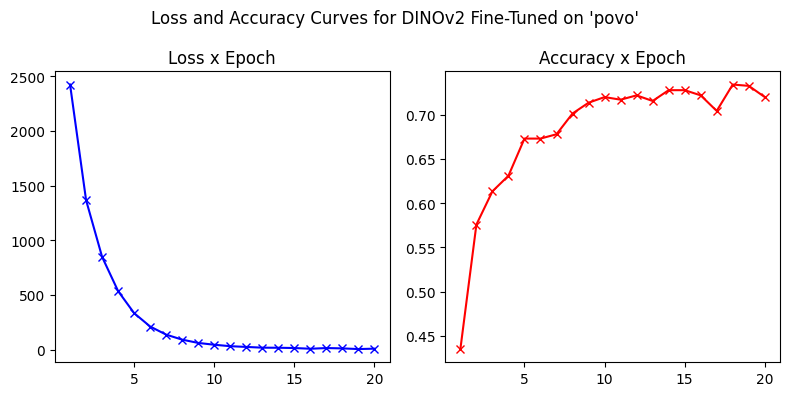

Validation accuracy: 0.73388671875
Validation average per class precision: 0.7125
Validation average per class recall: 0.6982



/home/lui/Documents/uva/thesis/tainacan_collection/image_based/image_training_utils.py:687: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('../data/mo

Test accuracy: 0.6916376352310181
Test average per class precision: 0.6941
Test average per class recall: 0.6634



In [38]:
# Retraining model with augmented dataset to see the difference in the results
batch_size = 16
epochs = 20
num_classes = len(povo_filtered_categories)
model = DINOClassifier(num_classes).to(device)
criterion = nn.CrossEntropyLoss(weight=povo_class_weights)
opt = optim.Adam(model.parameters(), lr=1e-6, weight_decay=3e-7)
model_name = 'balanced_dino_povo'
column_name = 'povo'

execute_train_test(povo_augmented_dataset, povo_balanced_test_dataset, device, batch_size, \
                   epochs, num_classes, model, criterion, opt, model_name, column_name, \
                   povo_balanced_val_dataset, architecture_name='DINOv2')

# _, _, \
# povo_dino_umap, povo_image_indices = compute_classifier_embeddings(povo_dataloader, model, \
#                                                                    device, 'dino')

# Cleaning up memory
clean_mem([model])

Training model:   5%|██▎                                          | 1/20 [05:57<1:53:08, 357.30s/it]

Best model saved at epoch 1
Epoch 1, Loss: 2591.7678, Validation Accuracy: 0.3944


Training model:  10%|████▌                                        | 2/20 [12:01<1:48:20, 361.14s/it]

Best model saved at epoch 2
Epoch 2, Loss: 1644.0496, Validation Accuracy: 0.5258


Training model:  15%|██████▊                                      | 3/20 [17:54<1:41:15, 357.39s/it]

Best model saved at epoch 3
Epoch 3, Loss: 1188.5501, Validation Accuracy: 0.5728


Training model:  20%|█████████                                    | 4/20 [23:58<1:35:59, 359.98s/it]

Best model saved at epoch 4
Epoch 4, Loss: 881.8132, Validation Accuracy: 0.6291


Training model:  25%|███████████▎                                 | 5/20 [30:11<1:31:13, 364.87s/it]

Best model saved at epoch 5
Epoch 5, Loss: 657.5092, Validation Accuracy: 0.6510


Training model:  30%|█████████████▌                               | 6/20 [36:36<1:26:43, 371.69s/it]

Best model saved at epoch 6
Epoch 6, Loss: 491.8428, Validation Accuracy: 0.6854


Training model:  35%|███████████████▋                             | 7/20 [42:55<1:21:02, 374.00s/it]

Best model saved at epoch 7
Epoch 7, Loss: 366.9791, Validation Accuracy: 0.6995


Training model:  40%|██████████████████                           | 8/20 [49:07<1:14:42, 373.52s/it]

Epoch 8, Loss: 272.7254, Validation Accuracy: 0.6964


Training model:  45%|████████████████████▎                        | 9/20 [55:18<1:08:18, 372.57s/it]

Best model saved at epoch 9
Epoch 9, Loss: 201.7902, Validation Accuracy: 0.7027


Training model:  50%|█████████████████████                     | 10/20 [1:01:33<1:02:14, 373.46s/it]

Best model saved at epoch 10
Epoch 10, Loss: 147.6787, Validation Accuracy: 0.7261


Training model:  55%|████████████████████████▏                   | 11/20 [1:07:52<56:15, 375.06s/it]

Best model saved at epoch 11
Epoch 11, Loss: 108.0167, Validation Accuracy: 0.7308


Training model:  60%|██████████████████████████▍                 | 12/20 [1:14:13<50:14, 376.81s/it]

Best model saved at epoch 12
Epoch 12, Loss: 80.8898, Validation Accuracy: 0.7387


Training model:  65%|████████████████████████████▌               | 13/20 [1:20:40<44:18, 379.85s/it]

Best model saved at epoch 13
Epoch 13, Loss: 59.6656, Validation Accuracy: 0.7496


Training model:  70%|██████████████████████████████▊             | 14/20 [1:27:00<38:00, 380.14s/it]

Best model saved at epoch 14
Epoch 14, Loss: 43.6151, Validation Accuracy: 0.7512


Training model:  75%|█████████████████████████████████           | 15/20 [1:33:07<31:20, 376.11s/it]

Epoch 15, Loss: 32.5798, Validation Accuracy: 0.7465


Training model:  80%|███████████████████████████████████▏        | 16/20 [1:39:05<24:42, 370.65s/it]

Best model saved at epoch 16
Epoch 16, Loss: 25.5009, Validation Accuracy: 0.7527


Training model:  85%|█████████████████████████████████████▍      | 17/20 [1:45:10<18:26, 368.83s/it]

Epoch 17, Loss: 18.4044, Validation Accuracy: 0.7480


Training model:  90%|███████████████████████████████████████▌    | 18/20 [1:51:12<12:13, 366.73s/it]

Best model saved at epoch 18
Epoch 18, Loss: 14.0368, Validation Accuracy: 0.7543


Training model:  95%|█████████████████████████████████████████▊  | 19/20 [1:57:10<06:04, 364.40s/it]

Best model saved at epoch 19
Epoch 19, Loss: 10.6667, Validation Accuracy: 0.7559


Training model: 100%|████████████████████████████████████████████| 20/20 [2:03:09<00:00, 369.47s/it]


Best model saved at epoch 20
Epoch 20, Loss: 7.8420, Validation Accuracy: 0.7574


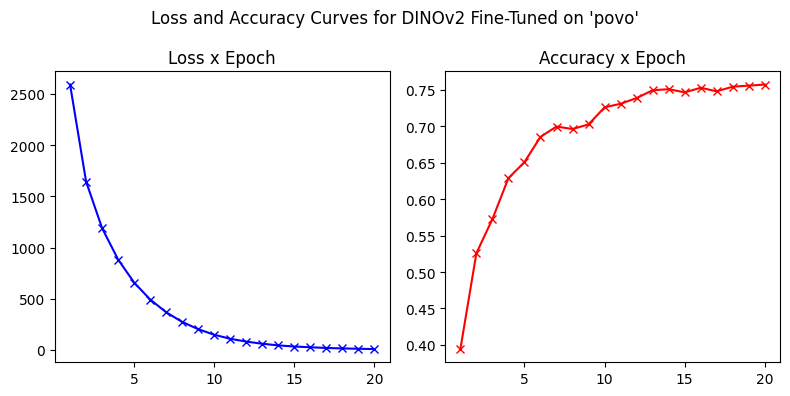

Validation accuracy: 0.75732421875
Validation average per class precision: 0.7359
Validation average per class recall: 0.7166

Test accuracy: 0.7299651503562927
Test average per class precision: 0.7589
Test average per class recall: 0.7245



Computing embeddings: 100%|███████████████████████████████████████| 705/705 [03:01<00:00,  3.89it/s]
/home/lui/anaconda3/envs/ind_thesis/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [39]:
# Training partially frozen model on balanced dataset to see the difference in results
batch_size = 16
epochs = 20
num_classes = len(povo_filtered_categories)
freeze = 9
model = DINOClassifier(num_classes, freeze=freeze).to(device)
criterion = nn.CrossEntropyLoss(weight=povo_class_weights)
opt = optim.Adam(model.parameters(), lr=1e-6, weight_decay=3e-7)
model_name = 'frozen_dino_povo'
column_name = 'povo'

execute_train_test(povo_augmented_dataset, povo_balanced_test_dataset, device, \
                   batch_size, epochs, num_classes, model, criterion, opt, model_name, \
                   column_name, povo_balanced_val_dataset, architecture_name='DINOv2')

_, _, \
povo_dino_umap, povo_image_indices = compute_classifier_embeddings(povo_dataloader, model, \
                                                                   device, 'dino')

# Cleaning up memory
clean_mem([model])

#### *categoria* Column

Training model:   5%|██▎                                          | 1/20 [05:03<1:35:57, 303.00s/it]

Best model saved at epoch 1
Epoch 1, Loss: 394.4000, Validation Accuracy: 0.8512


Training model:  10%|████▌                                        | 2/20 [10:13<1:32:11, 307.33s/it]

Best model saved at epoch 2
Epoch 2, Loss: 159.4989, Validation Accuracy: 0.8670


Training model:  15%|██████▊                                      | 3/20 [15:24<1:27:33, 309.02s/it]

Best model saved at epoch 3
Epoch 3, Loss: 62.2793, Validation Accuracy: 0.8906


Training model:  20%|█████████                                    | 4/20 [20:34<1:22:31, 309.48s/it]

Epoch 4, Loss: 32.4793, Validation Accuracy: 0.8877


Training model:  25%|███████████▎                                 | 5/20 [25:36<1:16:43, 306.92s/it]

Epoch 5, Loss: 32.3847, Validation Accuracy: 0.8552


Training model:  30%|█████████████▌                               | 6/20 [30:39<1:11:16, 305.45s/it]

Epoch 6, Loss: 31.2179, Validation Accuracy: 0.8808


Training model:  35%|███████████████▋                             | 7/20 [35:41<1:05:56, 304.37s/it]

Epoch 7, Loss: 30.7176, Validation Accuracy: 0.8847


Training model:  40%|██████████████████                           | 8/20 [40:43<1:00:42, 303.50s/it]

Epoch 8, Loss: 42.3832, Validation Accuracy: 0.8847


Training model:  45%|█████████████████████▏                         | 9/20 [45:46<55:35, 303.24s/it]

Epoch 9, Loss: 15.1350, Validation Accuracy: 0.8601


Training model:  45%|████████████████████▎                        | 9/20 [50:48<1:02:05, 338.69s/it]

Early-stopping training!


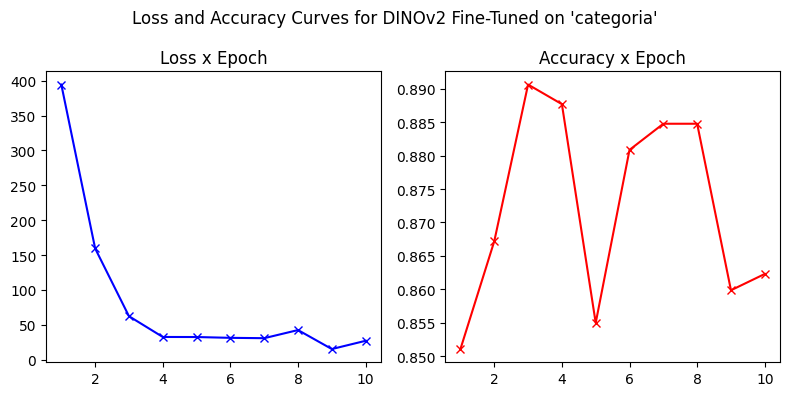

/home/lui/Documents/uva/thesis/tainacan_collection/image_based/image_training_utils.py:687: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('../data/mo

Validation accuracy: 0.890625
Validation average per class precision: 0.8820
Validation average per class recall: 0.8192

Test accuracy: 0.874889075756073
Test average per class precision: 0.8449
Test average per class recall: 0.7881

Test average precision on filtered classes: 0.8276418579949273
Test average recall on filtered classes: 0.8571928408410814


In [40]:
# Now creating the 'categoria' dataset
categoria_dataset = ImageDataset(categoria_labels, transform=dino_transform)
categoria_dataloader = DataLoader(categoria_dataset, batch_size=8, shuffle=True, \
                                  num_workers=0, pin_memory=True)

# Recreating datasets for proper training and testing
categoria_train_val_dataset = ImageDataset(categoria_train_val_labels, \
                                           transform=dino_transform, augment=False)
categoria_test_dataset = ImageDataset(categoria_test_labels, transform=dino_transform, \
                                      augment=False)

# Setting-up training, executing training and then running tests
batch_size = 16
epochs = 20
num_classes = ind_df['categoria'].dropna().nunique()
model = DINOClassifier(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters(), lr=1e-6, weight_decay=3e-7)
model_name = 'dino_categoria'
column_name = 'categoria'

test_prec, test_rec = execute_train_test(categoria_train_val_dataset, categoria_test_dataset, \
                                         device, batch_size, epochs, num_classes, model, \
                                         criterion, opt, model_name, column_name, \
                                         architecture_name='DINOv2')
prec_rec_on_selected_classes(categoria_categories, categoria_filtered_categories, test_prec, \
                             test_rec)

# Cleaning up memory
clean_mem([model])

In [41]:
# Filtering dataframe for selected categories. We need to recompute this part of the dataset
# because of the different transform used
threshold_multiplier = 1.5
minority_classes, majority_classes, labels_minority, labels_majority, \
val_labels, test_labels, categoria_augmented_dataset, categoria_balanced_val_dataset, \
categoria_balanced_test_dataset = \
filter_image_data_distribution(ind_df, categoria_filtered_categories_names, dino_transform, \
                               threshold_multiplier, 'categoria')

In [ ]:
# Retraining model with augmented dataset to see the difference in the results
batch_size = 16
epochs = 20
num_classes = len(categoria_filtered_categories)
model = DINOClassifier(num_classes).to(device)
criterion = nn.CrossEntropyLoss(weight=categoria_class_weights)
opt = optim.Adam(model.parameters(), lr=3e-6, weight_decay=1e-6)
model_name = 'balanced_dino_categoria'
column_name = 'categoria'

execute_train_test(categoria_augmented_dataset, categoria_balanced_test_dataset, device, \
                   batch_size, epochs, num_classes, model, criterion, opt, model_name, \
                   column_name, categoria_balanced_val_dataset, architecture_name='DINOv2')

# _, _, \
# categoria_dino_umap, categoria_image_indices = \
# compute_classifier_embeddings(categoria_dataloader, model, device, 'dino')

# Cleaning up memory
clean_mem([model])

Training model:   5%|██▎                                          | 1/20 [15:01<4:45:28, 901.51s/it]

Best model saved at epoch 1
Epoch 1, Loss: 778.2861, Validation Accuracy: 0.8721


Training model:  10%|████▌                                        | 2/20 [30:15<4:32:34, 908.59s/it]

Best model saved at epoch 2
Epoch 2, Loss: 195.1081, Validation Accuracy: 0.8960


Training model:  15%|██████▊                                      | 3/20 [44:24<4:09:48, 881.70s/it]

Best model saved at epoch 3
Epoch 3, Loss: 97.0480, Validation Accuracy: 0.9034


Training model:  20%|█████████                                    | 4/20 [58:36<3:51:58, 869.94s/it]

Epoch 4, Loss: 49.7222, Validation Accuracy: 0.8905


Training model:  25%|██████████▊                                | 5/20 [1:13:41<3:40:39, 882.62s/it]

Best model saved at epoch 5
Epoch 5, Loss: 55.7649, Validation Accuracy: 0.9190


Training model:  30%|████████████▉                              | 6/20 [1:29:01<3:28:51, 895.10s/it]

Epoch 6, Loss: 36.6831, Validation Accuracy: 0.9006


Training model:  35%|███████████████                            | 7/20 [1:43:45<3:13:11, 891.63s/it]

Epoch 7, Loss: 24.9176, Validation Accuracy: 0.8988


In [ ]:
# Training partially frozen model on balanced dataset to see the difference in results
batch_size = 16
epochs = 20
num_classes = len(categoria_filtered_categories)
freeze = 7
model = DINOClassifier(num_classes, freeze=freeze).to(device)
criterion = nn.CrossEntropyLoss(weight=categoria_class_weights)
opt = optim.Adam(model.parameters(), lr=2e-5, weight_decay=2e-6)
model_name = 'frozen_dino_categoria'
column_name = 'categoria'

execute_train_test(categoria_augmented_dataset, categoria_balanced_test_dataset, device, \
                   batch_size, epochs, num_classes, model, criterion, opt, model_name, \
                   column_name, categoria_balanced_val_dataset, architecture_name='DINOv2')

_, _, \
categoria_dino_umap, categoria_image_indices = \
compute_classifier_embeddings(categoria_dataloader, model, device, 'dino')

# Cleaning up memory
clean_mem([model])

#### Multi-Head Training

In [ ]:
# Filtering dataframe for selected categories
threshold_multiplier = 2
minority_classes, majority_classes, labels_minority, labels_majority, \
val_labels, test_labels, multi_augmented_dataset, multi_balanced_val_dataset, \
multi_balanced_test_dataset = \
multihead_filter_image_data_distribution(ind_df, [multi_povo_filtered_categories_names, \
                                         multi_categoria_filtered_categories_names], \
                                         dino_transform, threshold_multiplier, \
                                         ['povo', 'categoria'])

In [ ]:
# Because the dataset is still unbalanced, we also create class weights for the loss function
multi_povo_class_weights = multihead_compute_class_weights(multi_povo_filtered_categories, \
                                                           labels_minority, labels_majority, \
                                                           device, threshold_multiplier, \
                                                           'povo')

multi_categoria_class_weights = \
multihead_compute_class_weights(multi_categoria_filtered_categories, labels_minority, \
                                labels_majority, device, threshold_multiplier,'categoria')

In [ ]:
import image_training_utils
importlib.reload(image_training_utils)
from image_training_utils import *

# Training multi-head model on balanced dataset to see the difference in results
batch_size = 8
epochs = 20
num_classes = [len(multi_povo_filtered_categories), len(multi_categoria_filtered_categories)]
model = DINOClassifier(num_classes[0], num_classes[1]).to(device)
criterions = [nn.CrossEntropyLoss(weight=multi_povo_class_weights), \
              nn.CrossEntropyLoss(weight=multi_categoria_class_weights)]
opt = optim.Adam(model.parameters(), lr=3e-6, weight_decay=1e-6)
model_name = 'multihead_dino'
column_names = ['povo', 'categoria']
arch_name = 'DINOv2'
head_weights = [0.5, 0.5]

multihead_execute_train_test(multi_augmented_dataset, multi_balanced_test_dataset, device, \
                             batch_size, epochs, num_classes, model, \
                             criterions, opt, model_name, column_names, \
                             multi_balanced_val_dataset, arch_name, head_weights)

_, _, multihead_dino_umap, \
multihead_image_indices = compute_classifier_embeddings(categoria_dataloader, model, device)

# Cleaning up memory
clean_mem([model])

### Visualizing and Comparing Projections

In [ ]:
# Normalizing data for later plot on tool
vanilla_dino_umap = normalize(vanilla_dino_umap, norm_factor)
povo_dino_umap = normalize(povo_dino_umap, norm_factor)
categoria_dino_umap = normalize(categoria_dino_umap, norm_factor)

In [ ]:
# Visualizing resulting projections
plt.figure(figsize=(12,8))
plt.suptitle('Comparing ViT and DINO Projections')

# Plotting all ViT projections
projs = [vanilla_vit_umap, povo_vit_umap, categoria_vit_umap, multihead_vit_umap]
proj_names = ["Vanilla ViT", "'povo' ViT", "'categoria' ViT", "Multi-head ViT"]
row_scatter_plot(projs, proj_names, 1, 'b', 2, 4)

# Plotting all DINO projections
projs = [vanilla_dino_umap, povo_dino_umap, categoria_dino_umap, multihead_dino_umap]
proj_names = ["Vanilla DINO", "'povo' DINO", "'categoria' DINO", "Multi-head DINO"]
row_scatter_plot(projs, proj_names, 2, 'r', 2, 4)

plt.tight_layout()
plt.show()

### Visualizing Clusters

In [ ]:
# Filtering dataframe to get only the part that contains images
filtered_df = ind_df.loc[ind_df['image_path'].notna()]

# Visualizing 'povo' cluster
visualizing_clusters(filtered_df, povo_dino_umap, povo_image_indices, 'povo', 'UMAP')

In [ ]:
# Visualizing 'categoria' cluster
visualizing_clusters(filtered_df, categoria_dino_umap, categoria_image_indices, \
                     'categoria', 'UMAP')

In [ ]:
# Visualizing 'povo' cluster for multi-head modedl
visualizing_clusters(filtered_df, multihead_dino_umap, multihead_image_indices, \
                     'povo', 'UMAP')

In [ ]:
# Visualizing 'categoria' cluster for multi-head modedl
visualizing_clusters(filtered_df, multihead_dino_umap, multihead_image_indices, \
                     'categoria', 'UMAP')

In [ ]:
# Saving outputs for visualization tool
_ = saving_outputs(filtered_df, povo_labels, vanilla_dino_umap, vanilla_image_indices, \
                   save_file='vanilla_dino.csv', no_clusters=True)

_ = saving_outputs(filtered_df, povo_labels, povo_dino_umap, povo_image_indices, 'povo', \
                   'povo_dino.csv')

_ = saving_outputs(filtered_df, categoria_labels, categoria_dino_umap, \
                   categoria_image_indices, 'categoria', 'categoria_dino.csv')

_ = saving_outputs(filtered_df, povo_labels, multihead_dino_umap, \
                   multihead_image_indices, save_file='multihead_dino.csv', no_clusters=True)